### Read me

* This codebook is used once all the videos have been annotated and cleaned up (where json files in the outputs folder and starting with 'ATTN_' are checked and fixed). 

* Calculate features from the output json files using 'features/calculate_features.py'
* outcome files (conf_teams_year.xlsx) are downloaded from sharepoint and stored in data/conf_name


### Extract outcome variables from excel sheret

In [3]:
import pandas as pd
import json
import os
from pathlib import Path

In [4]:
# Load the CSV file
conf_name = "2021ABI"
csv_file_path = f"/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/ABI_teams_2021.xlsx"
df = pd.read_excel(csv_file_path)

# Process the data
teams_data = []
for index, row in df.iterrows():
    team_id = row['team_id']
    funded_status = 1 if row['funding_status'] == 'funded' else 0
    team_members = row['team_members'].split(', ')
    
    team_info = {
        "team_id": team_id,
        "funded_status": funded_status,
        "members": team_members
    }
    teams_data.append(team_info)

output_file_path = f'/Users/eveyhuang/Documents/NICO/gemini_code/data/{conf_name}/{conf_name}_outcome.json'

# Save the teams_data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(teams_data, json_file, indent=4)

# Output the result
print(teams_data)

[{'team_id': 'ABI1', 'funded_status': 0, 'members': ['Qian Liu', 'Anna-Karin Gustavsson']}, {'team_id': 'ABI2', 'funded_status': 1, 'members': ['Douglas Shepherd', 'Shannon Quinn', 'Domenico (Nick) Galati']}, {'team_id': 'ABI3', 'funded_status': 0, 'members': ['Alexandra Dickinson', 'Barbara Smith']}, {'team_id': 'ABI4', 'funded_status': 0, 'members': ['Shwetadwip Chowdhury', 'Candace Fleischer']}, {'team_id': 'ABI5', 'funded_status': 1, 'members': ['Aseema Mohanty', 'Srigokul Upadhyayula']}, {'team_id': 'ABI6', 'funded_status': 1, 'members': ['Allison Dennis', 'Carolyn Bayer']}, {'team_id': 'ABI7', 'funded_status': 0, 'members': ['Dylan Burnette', 'Ulugbek Kamilov', 'Mark Sellmyer']}, {'team_id': 'ABI8', 'funded_status': 0, 'members': ['Morteza Mahmoudi', 'Lingyan Shi', 'Shiva Abbaszadeh']}, {'team_id': 'ABI9', 'funded_status': 1, 'members': ['Ulugbek Kamilov', 'Lu Wei', 'Benjamin Bartelle']}, {'team_id': 'ABI10', 'funded_status': 0, 'members': ['Uzay Emir', 'Domenico (Nick) Galati']}

### merge data for each session in output into data folder

In [5]:
import re

def add_times(time1, time2):
    
    # Split the time strings into hours and minutes
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    # Add the hours and minutes separately
    total_hours = hours1 + hours2
    total_minutes = minutes1 + minutes2
    
    # If total minutes are 60 or more, convert to hours
    if total_minutes >= 60:
        total_hours += total_minutes // 60
        total_minutes = total_minutes % 60
    
    #print(f"adding {time1} and {time2} result is {total_hours:02}:{total_minutes:02}")
    # Format the result as "HH:MM"
    return f"{total_hours:02}:{total_minutes:02}"

def normalize_name(full_string):
    """
    Extracts just the name from various formats of name strings.
    
    Args:
        full_string: String containing name and additional information
        
    Returns:
        String containing just the name
    
    """
    # Remove common titles
    full_string = re.sub(r'^(Dr\.?|Prof\.?|Professor|Mr\.?|Ms\.?|Mrs\.?)\s+', '', full_string, flags=re.IGNORECASE)
    
    # Remove everything after common separators
    for separator in [' (', '-', ',']:
        if separator in full_string:
            full_string = full_string.split(separator)[0]
    
    # Clean up any remaining whitespace
    name = full_string.strip()
    
    name = name.replace('.', '')
    # Handle cases where institution is connected with a hyphen without space
    parts = name.split('-')
    if len(parts) > 1:
        # Check if the part after hyphen contains "University" or similar institutional words
        if any(word in parts[-1].lower() for word in ['university', 'college', 'institute', 'school', 'u of']):
            name = parts[0].strip()
    
    return name

def split_name(name):
    """Split a name into first and last (handles middle names by joining all but last as first)."""
    parts = name.strip().split()
    if len(parts) == 1:
        return parts[0], ""
    return " ".join(parts[:-1]), parts[-1]
from difflib import SequenceMatcher

def find_matching_name(name, correct_names, last_name_threshold=0.9, first_name_threshold=0.3):
    """
    Fuzzy match names, requiring a strong match on last name and a looser match on first name.
    """
    name_first, name_last = split_name(name.lower())
    best_match = None
    best_score = 0

    for correct_name in correct_names:
        correct_first, correct_last = split_name(correct_name.lower())
        # Compare last names
        last_ratio = SequenceMatcher(None, name_last, correct_last).ratio()
        if last_ratio >= last_name_threshold:
            # Compare first names
            first_ratio = SequenceMatcher(None, name_first, correct_first).ratio()
            # Use average or weighted score for ranking
            score = (last_ratio + first_ratio) / 2
            if first_ratio >= first_name_threshold and score > best_score:
                best_score = score
                best_match = correct_name

    if best_match:
        return best_match, best_score
    return None, 0

# Example usage with more complex cases:
def find_and_correct_name(name, correct_names, threshold=0.8):
    """
    Wrapper function that provides more detailed output about name matching.
    
    Args:
        name: String containing the potentially misspelled name
        correct_names: List of correctly spelled names
        threshold: Float between 0 and 1, minimum similarity ratio to consider a match
        
    Returns:
        Dictionary containing matching information
    """
    name = normalize_name(name)
    match, ratio = find_matching_name(name, correct_names, threshold)
    result = {
        "input_name": name,
        "matched_name": match,
        "similarity": round(ratio, 3),
        "is_match": ratio >= threshold
    }
    
    return result

In [6]:
# CHANGE conf name here 
conf_name = '2022MND'

conference_dir = f'data/{conf_name}'
gemini_output_dir = f'outputs/{conf_name}'
output_dir = f'data/{conf_name}'

In [7]:
import os
import json
from collections import defaultdict


with open(f'data/{conf_name}/{conf_name}_outcome.json') as f:
    teams_data = json.load(f)

team_data_names = set()

for team in teams_data:
    members = team['members']
    for name in members:
        team_data_names.add(name)


def normalize_keys(entry):
    normalized = {}
    for key, value in entry.items():
        normalized[key.replace(' ', '_')] = value
    return normalized

def convert_time_to_seconds(time_str):
    """
    Convert time string in format "MM:SS" or "M:SS" to total seconds.
    Also handles numeric strings that are already in seconds.
    """
    if isinstance(time_str, (int, float)):
        return int(time_str)
    
    time_str = str(time_str).strip()
    
    # If it's already a number, return it
    try:
        return int(time_str)
    except ValueError:
        pass
    
    # Handle time format like "3:59" or "03:59"
    if ':' in time_str:
        parts = time_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:
            # Handle HH:MM:SS format
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
    
    # If we can't parse it, return 0
    print(f"Warning: Could not parse time string '{time_str}', using 0 seconds")
    return 0
# merge data from output folders 
def merge_json_files(directory):
    merged_data = []
    all_speakers = []
    speaking_length = 0
    last_end_time = "00:00"
    unmatch_names = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith("all_llama") and file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    for entry in data:
                        entry = normalize_keys(entry)
                        
                        
                        match_name_result = find_and_correct_name(entry['speaker'], team_data_names)
                        if match_name_result['is_match']:
                            entry['speaker'] = match_name_result['matched_name']
                        else:
                            entry['speaker'] = match_name_result['input_name']
                            unmatch_names.add(entry['speaker'])
                        all_speakers.append(entry['speaker'])
                        if type(entry['speaking_duration']) == str:
                            entry['speaking_duration'] = convert_time_to_seconds(entry['speaking_duration'])
                        speaking_length += int(entry['speaking_duration'])
                        entry['start_time'] = add_times(entry['start_time'], last_end_time)
                        entry['end_time'] = add_times(entry['end_time'], last_end_time)
                            
                        merged_data.append(entry)
                    try:    
                        last_end_time = max(entry['end_time'] for entry in data)
                    except ValueError:
                        print(f"Error processing file {file_path}: {data}")
                        continue
                    
    unique_speakers = set(all_speakers)   
    print(f"{directory}, unmatched names: {unmatch_names}")             
    return merged_data, list(unique_speakers), speaking_length



if not os.path.exists(output_dir):
     os.makedirs(output_dir)

for folder in os.listdir(gemini_output_dir):
     if folder.startswith("output"):
          folder_path = os.path.join(gemini_output_dir, folder)
          merged_data, all_speaker, speaking_length = merge_json_files(folder_path)
          
          result = {
                "all_speakers": all_speaker,
                "total_speaking_length": speaking_length,
                "all_data": merged_data,     
          }
          
          output_file_name = folder.replace("output_", "").strip()
          output_file_path = os.path.join(output_dir, f"{output_file_name}.json")
          
          with open(output_file_path, 'w') as f:
                json.dump(result, f, indent=4)


outputs/2022MND/output_2022_04_07_MND_S5, unmatched names: {'Tom Mansell', 'Richard Wiener', 'Rosa Krajmalnik', 'Melanie Gareau', 'Andrew Feig', 'Unidentified Speaker'}
outputs/2022MND/output_2022_04_07_MND_S2, unmatched names: {'Sandra Laney', 'Heather Bean', 'Rima kaddurah daouk', 'Mei Shen_University of Illinois at Urbana', 'Kai Zhang | UIUC', 'Heather Bean | ASU', 'Barbara Bendlin', 'Alexandra Basford'}
outputs/2022MND/output_2022_04_07_MND_S3, unmatched names: {'JP Yu', 'Irene Yang', 'Ali Keshavarzi', 'Chris Whidbey', 'Richard Wiener', 'Rachel Saylor', 'Ali Keshavarzian', 'Wenjing Wang', 'Andrew Feig', 'Jodi Lilley'}
outputs/2022MND/output_2022_04_07_MND_S4, unmatched names: {'Tom Mansell', 'Rosa Krajmalnik', 'Okay', 'Melanie Gareau', 'Andrew Feig'}
outputs/2022MND/output_2022_04_08_MND_S6, unmatched names: {'George Weinstock', 'Mark Mimee'}
outputs/2022MND/output_2022_04_08_MND_S1, unmatched names: {'Emily Balskus', 'Irene Yang', 'Heather Bean', 'Richard Wiener', 'Melanie Gareau'

In [8]:
# Read outcome.json to get team information (match each person to their team and funding status)

outcome_file = os.path.join(conference_dir, f'{conf_name}_outcome.json')
with open(outcome_file, 'r') as f:
    outcome_data = json.load(f)

# Create a mapping of normalized full names to their team IDs
name_to_teams = defaultdict(list)  # Changed to defaultdict to store multiple teams per person
for proposal in outcome_data:
    team_id = proposal.get('team_id', '')
    member_names = proposal.get('members', [])
    funded_status = proposal.get('funded_status', None)
    
    if member_names:
        for name in member_names:
            
            name_to_teams[name].append({
                'team_id': team_id,
                'full_name': name,
                'funded_status': funded_status
            })


with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'w') as f:
    data = json.dump(name_to_teams, f, indent=4)

print(data)

None


In [9]:
from collections import defaultdict, OrderedDict

with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'r') as f:
    name_to_teams = json.load(f)
    
all_sessions = OrderedDict()

# Process each JSON file in the directory
for filename in os.listdir(conference_dir):
    if filename.endswith('.json') and filename != f'{conf_name}_outcome.json':
        file_path = os.path.join(conference_dir, filename)
        
        
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
            except:
                print(f"Error loading {filename}")
                continue
        
        if "all_speakers" in data:
            # Create an ordered dictionary for this session
            session_data = OrderedDict()
            session_data["all_speakers"] = list(set(data["all_speakers"]))
            
            # Find teams present in this session
            teams_in_session = defaultdict(list)
            for name in data["all_speakers"]:
                
                if name in name_to_teams:
                    # Add person to all their teams
                    for team_info in name_to_teams[name]:
                        teams_in_session[team_info['team_id']].append({
                            'name': team_info['full_name'],
                            'funded_status': team_info['funded_status'],
                            'team_id': team_info['team_id']
                        })
                
            
            # Add team information to session data, only including teams with at least 2 members
            if teams_in_session:
                session_data["teams"] = OrderedDict()
                for team_id, team_info in teams_in_session.items():
                    if len(team_info) >= 2:  # Only include teams with 2 or more members
                        session_data["teams"][team_id] = {
                            "members": [member['name'] for member in team_info],
                            "funded_status": team_info[0]['funded_status'] if team_info else None
                        }
            
            # Add to the main dictionary using the filename (without .json) as the key
            session_name = os.path.splitext(filename)[0]
            all_sessions[session_name] = session_data
            
            
        else:
            print(f"Skipping {filename} because it doesn't contain 'all_speakers'")


seen_names = set()
for session_data in all_sessions.values():
    if "all_speakers" in session_data:
        seen_names.update(session_data["all_speakers"])

# Step 2: Find unmatched names
unmatched_names = set(name_to_teams.keys()) - seen_names

# Step 3: Print them
print("*** Names in outcome.json not identified in any session (could be due to different spellings or typos):")
for name in unmatched_names:
    print(name)
    
all_sessions['missing_names'] = list(unmatched_names)
# Step 2: Find people not in any team
not_in_any_team = seen_names - set(name_to_teams.keys())

# Step 3: Print them
print("*** People in sessions who never joined any team:")
for name in not_in_any_team:
    print(name)

all_sessions['people_not_in_any_team'] = list(set(not_in_any_team))
with open(f'data/{conf_name}/{conf_name}_session_outcomes.json', 'w') as f:
    data = json.dump(all_sessions, f, indent=4)


Skipping 2022MND_session_outcomes.json because it doesn't contain 'all_speakers'
Skipping 2022MND_person_to_team.json because it doesn't contain 'all_speakers'
*** Names in outcome.json not identified in any session (could be due to different spellings or typos):
Kaixiong Ye
*** People in sessions who never joined any team:
Corinne Maurice
Judith Eisen
Heather Bean
Richard Wiener
Rima kaddourah daouk
Tom Mansell
Elizabeth Weiss
Melanie Gareau
Silvia Ronco
Mark Mimee
JP Yu
Aaron Longbrake
Judith Elsen
KaiXiong
Annika
Rima kaddurah daouk
Ali Keshavarzi
Rosa Krajmalnik
Andrew Feig
Jaehyun
Carolina Tropini
Leah Pyter OSU
Emily Balskus
Sandra Laney
George Weinstock JAX Genomic Medicine
Kai Zhang | UIUC
Rachel Saylor
Kaixiong
Unidentified Speaker
George Weinstock
Heather Bean | ASU
Jaeyun
George Weinstock Jackson
Lisa Ryno
Alexandra Basford
Irene Yang
Gianna Hammer | Duke
Mei Shen_University of Illinois at Urbana
Chris Whidbey
Ali Keshavarzian
Okay
Wenjing Wang
Leah Pyter
Kaiwong
Barbara Ben

### Merge all features and outcomes

In [16]:


"""
Creates a DataFrame called 'all_data' from featurized data across all conferences.

Returns:
    pd.DataFrame: DataFrame with conference, session, and all feature columns
"""
conferences = ['2020NES', '2021ABI', '2021MND', '2021MZT', '2021SLU', '2021CMC', '2021NES', '2022MND']
all_data = []

for conf_name in conferences:
    # Path to featurized data directory for this conference
    featurized_dir = f'data/{conf_name}/featurized data'
    
    # Check if directory exists
    if not os.path.exists(featurized_dir):
        print(f"Warning: Directory {featurized_dir} does not exist, skipping...")
        continue
    
    # Get all JSON files in the featurized data directory
    json_files = [f for f in os.listdir(featurized_dir) if f.endswith('.json')]
    
    for json_file in json_files:
        # Create session name (filename without .json extension)
        session_name = json_file.replace('.json', '').replace('features_', '')
        
        # Load the JSON data
        json_path = os.path.join(featurized_dir, json_file)
        try:
            with open(json_path, 'r') as f:
                features = json.load(f)
            
            # Create row data
            row_data = {
                'conference': conf_name,
                'session': session_name
            }
            # Exclude multiple fields
            exclude_fields = []
            filtered_features = {k: v for k, v in features.items() if k not in exclude_fields}
            row_data.update(filtered_features)
            # Add all feature key-value pairs to the row
            #row_data.update(features)
            
            all_data.append(row_data)
            
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            continue
    
    # Create DataFrame
    all_data_df = pd.DataFrame(all_data)
    
    print(f"Created DataFrame with {len(all_data_df)} rows and {len(all_data_df.columns)} columns")
    print(f"Columns: {list(all_data_df.columns)}")
    
    print(all_data_df.head())

# Usage:
# all_data = create_all_data_dataframe()

Created DataFrame with 16 rows and 34 columns
Columns: ['conference', 'session', 'num_members', 'meeting_length', 'num_interruption', 'percent_time_screenshare', 'num_propose_new_idea', 'num_develop_idea', 'num_ask_question', 'num_signal_expertise', 'num_identify_gap', 'num_acknowledge_contribution', 'num_supportive_response', 'num_critical_response', 'num_offer_feedback', 'num_summarize_conversation', 'num_express_humor', 'num_encourage_participation', 'num_process_management', 'num_assign_task', 'num_clarify_goal', 'num_confirm_decision', 'num_people_ask_question', 'num_people_identify_gap', 'num_people_supportive_response', 'num_people_critical_response', 'num_people_offer_feedback', 'num_people_summarize_conversation', 'num_people_express_humor', 'num_people_encourage_participation', 'num_people_process_management', 'num_people_assign_task', 'num_people_clarify_goal', 'num_people_confirm_decision']
  conference             session  num_members  meeting_length  \
0    2020NES   2020

In [17]:

# Prepare lists to store the new columns
num_teams_list = []
num_funded_teams_list = []

for idx, row in all_data_df.iterrows():
    conf = row['conference']
    session = row['session']
    session_outcomes_path = f'data/{conf}/{conf}_session_outcomes.json'
    
    # Default values
    num_teams = 0
    num_funded_teams = 0
    
    try:
        with open(session_outcomes_path, 'r') as f:
            session_outcomes = json.load(f)
        
        session_data = session_outcomes.get(session, {})
        teams = session_data.get('teams', {})
        num_teams = len(teams)
        num_funded_teams = sum(1 for t in teams.values() if t.get('funded_status') == 1)
    except Exception as e:
        print(f"Error processing {conf} {session}: {e}")
    
    num_teams_list.append(num_teams)
    num_funded_teams_list.append(num_funded_teams)

# Add the new columns to the DataFrame
all_data_df['num_teams'] = num_teams_list
all_data_df['num_funded_teams'] = num_funded_teams_list


print(all_data_df[['conference', 'session', 'num_teams', 'num_funded_teams']].head())

  conference             session  num_teams  num_funded_teams
0    2020NES   2020_11_05_NES_S6          2                 0
1    2020NES   2020_11_06_NES_S1          2                 1
2    2020NES  2020_11_06_NES_S10          0                 0
3    2020NES   2020_11_06_NES_S7          2                 0
4    2020NES   2020_11_05_NES_S1          1                 0


In [12]:
print(all_data_df[all_data_df['conference'] == '2021MND'][['session', 'num_teams', 'num_funded_teams']])

               session  num_teams  num_funded_teams
40   2021_04_23_MND_S7          1                 0
41   2021_04_22_MND_S2          0                 0
42   2021_04_22_MND_S3          1                 0
43  2021_04_23_MND_S16          2                 0
44   2021_04_23_MND_S6          2                 0
45   2021_04_22_MND_S4          1                 1
46   2021_04_23_MND_S1          2                 0
47  2021_04_23_MND_S11          3                 1
48   2021_04_22_MND_S8          1                 0
49  2021_04_23_MND_S10          0                 0
50   2021_04_22_MND_S5          0                 0
51   2021_04_22_MND_S6          0                 0
52  2021_04_23_MND_S13          0                 0
53   2021_04_23_MND_S3          2                 0
54   2021_04_23_MND_S2          2                 1
55  2021_04_23_MND_S12          1                 0
56   2021_04_22_MND_S7          2                 0
57  2021_04_23_MND_S15          0                 0
58   2021_04

In [18]:
all_data_df.to_excel('data/all_data_df.xlsx', index=False)

### summary statistics

In [19]:
all_data_df=pd.read_excel('data/all_data_df.xlsx')


SUMMARY STATISTICS BY CONFERENCE

NUM TEAMS:
----------------------------------------
            count  mean   std  min  max
conference                             
2020NES        16  1.94  0.85    0    3
2021ABI        24  1.38  1.06    0    3
2021CMC        21  1.43  0.98    0    3
2021MND        24  1.04  0.95    0    3
2021MZT        15  1.47  2.03    0    8
2021NES        18  1.56  1.25    0    4
2021SLU        20  1.45  1.00    0    3
2022MND        18  1.00  0.97    0    3

NUM FUNDED TEAMS:
----------------------------------------
            count  mean   std  min  max
conference                             
2020NES        16  0.62  0.72    0    2
2021ABI        24  0.38  0.58    0    2
2021CMC        21  0.57  0.75    0    2
2021MND        24  0.21  0.41    0    1
2021MZT        15  0.73  1.39    0    5
2021NES        18  0.56  0.62    0    2
2021SLU        20  0.55  0.60    0    2
2022MND        18  0.33  0.49    0    1

MEETING LENGTH:
------------------------------------

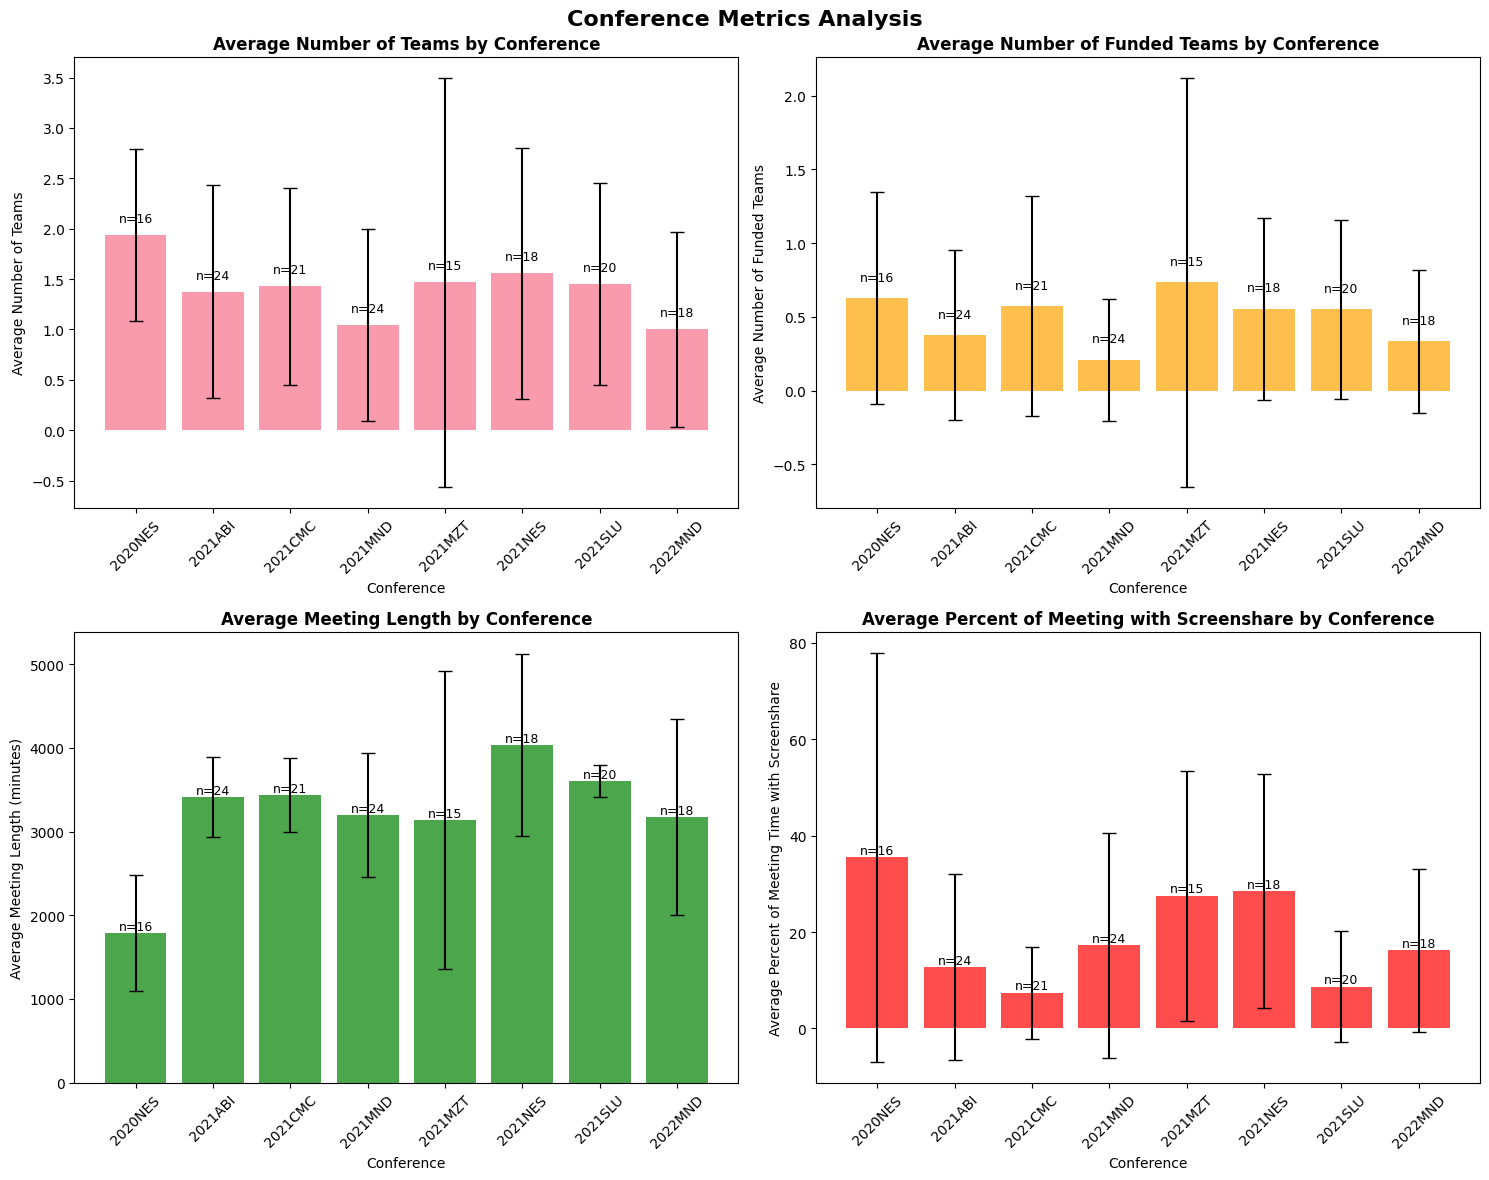

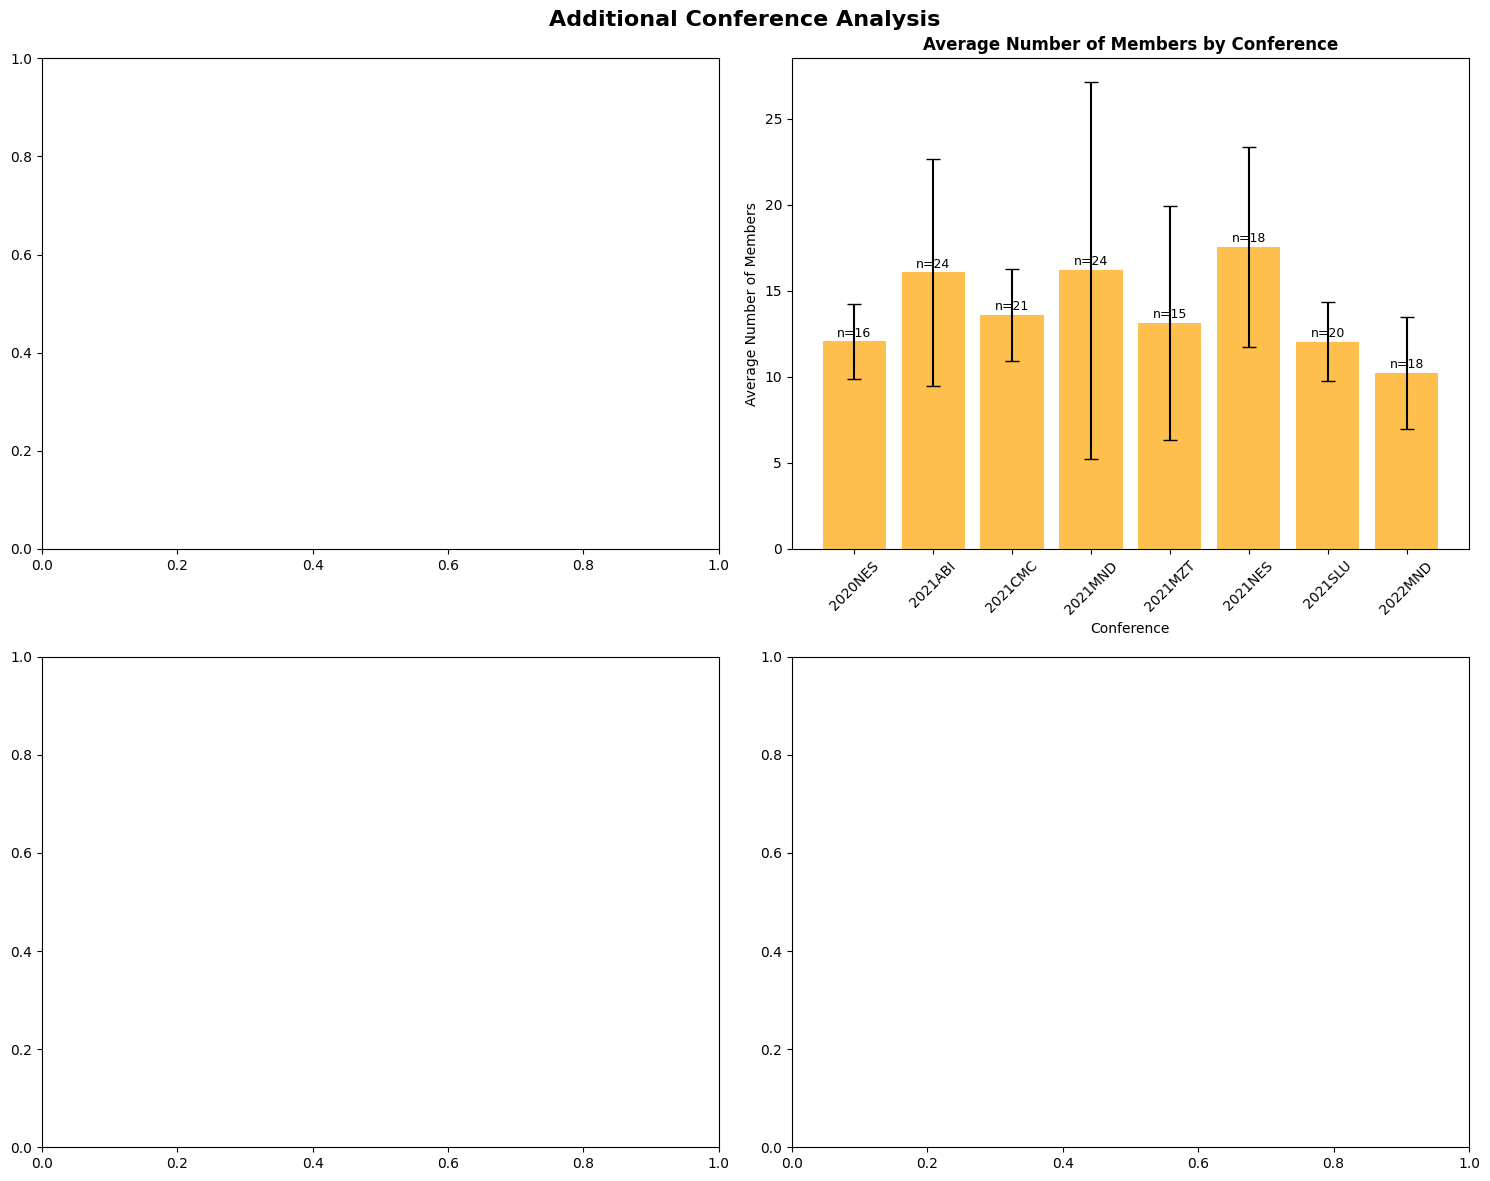

In [23]:
import seaborn as sns
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


def create_conference_visualizations(df):
    """Create visualizations for conference metrics"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Conference Metrics Analysis', fontsize=16, fontweight='bold')
    
    # 1. Number of Teams by Conference
    ax1 = axes[0, 0]
    if 'num_teams' in df.columns and 'conference' in df.columns:
        team_counts = df.groupby('conference')['num_teams'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax1.bar(team_counts['conference'], team_counts['mean'], 
                      yerr=team_counts['std'], capsize=5, alpha=0.7)
        ax1.set_title('Average Number of Teams by Conference', fontweight='bold')
        ax1.set_xlabel('Conference')
        ax1.set_ylabel('Average Number of Teams')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, team_counts['count'])):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'num_teams or conference column not found', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Number of Teams by Conference')
    
    # 2. Number of Funded Teams by Conference
    ax2 = axes[0, 1]
    if 'num_funded_teams' in df.columns and 'conference' in df.columns:
        funded_counts = df.groupby('conference')['num_funded_teams'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax2.bar(funded_counts['conference'], funded_counts['mean'], 
                      yerr=funded_counts['std'], capsize=5, alpha=0.7, color='orange')
        ax2.set_title('Average Number of Funded Teams by Conference', fontweight='bold')
        ax2.set_xlabel('Conference')
        ax2.set_ylabel('Average Number of Funded Teams')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, funded_counts['count'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'num_funded_teams or conference column not found', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Number of Funded Teams by Conference')
    
    # 3. Meeting Length by Conference
    ax3 = axes[1, 0]
    if 'meeting_length' in df.columns and 'conference' in df.columns:
        # Convert meeting_length to numeric if it's not already
        df['meeting_length_numeric'] = pd.to_numeric(df['meeting_length'], errors='coerce')
        
        meeting_stats = df.groupby('conference')['meeting_length_numeric'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax3.bar(meeting_stats['conference'], meeting_stats['mean'], 
                      yerr=meeting_stats['std'], capsize=5, alpha=0.7, color='green')
        ax3.set_title('Average Meeting Length by Conference', fontweight='bold')
        ax3.set_xlabel('Conference')
        ax3.set_ylabel('Average Meeting Length (minutes)')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, meeting_stats['count'])):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'meeting_length or conference column not found', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Meeting Length by Conference')
    
    # 4. Time Screenshare by Conference
    ax4 = axes[1, 1]
    if 'percent_time_screenshare' in df.columns and 'conference' in df.columns:
        # Convert time_screenshare to numeric if it's not already
        df['percent_time_screenshare_numeric'] = pd.to_numeric(df['percent_time_screenshare'], errors='coerce')
        
        screenshare_stats = df.groupby('conference')['percent_time_screenshare_numeric'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax4.bar(screenshare_stats['conference'], screenshare_stats['mean'], 
                      yerr=screenshare_stats['std'], capsize=5, alpha=0.7, color='red')
        ax4.set_title('Average Percent of Meeting with Screenshare by Conference', fontweight='bold')
        ax4.set_xlabel('Conference')
        ax4.set_ylabel('Average Percent of Meeting Time with Screenshare')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, screenshare_stats['count'])):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'time_screenshare or conference column not found', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Screenshare Time by Conference')
    
    plt.tight_layout()
    return fig

def create_additional_visualizations(df):
    """Create additional visualizations for deeper analysis"""
    
    if 'conference' not in df.columns:
        print("No conference column found for additional visualizations")
        return
    
    # Create a figure with subplots for additional analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Additional Conference Analysis', fontsize=16, fontweight='bold')
    
    # 1. Box plots for all metrics
    ax1 = axes[0, 0]
    metrics = ['num_teams', 'num_funded_teams', 'num_members']
    available_metrics = [m for m in metrics if m in df.columns]
    
    # 2. Average Number of Members by Conference
    ax2 = axes[0, 1]
    if 'num_members' in df.columns and 'conference' in df.columns:
        member_counts = df.groupby('conference')['num_members'].agg(['mean', 'std', 'count']).reset_index()
        
        bars = ax2.bar(member_counts['conference'], member_counts['mean'], 
                    yerr=member_counts['std'], capsize=5, alpha=0.7, color='orange')
        ax2.set_title('Average Number of Members by Conference', fontweight='bold')
        ax2.set_xlabel('Conference')
        ax2.set_ylabel('Average Number of Members')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, member_counts['count'])):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'num_members or conference column not found', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Number of Members by Conference')
        
    plt.tight_layout()
    return fig

def print_summary_statistics(df):
    """Print summary statistics for each conference"""
    if 'conference' not in df.columns:
        print("No conference column found")
        return
    
    print("\n" + "="*60)
    print("SUMMARY STATISTICS BY CONFERENCE")
    print("="*60)
    
    metrics = ['num_teams', 'num_funded_teams', 'meeting_length', 'percent_time_screenshare', 'num_members']
    available_metrics = [m for m in metrics if m in df.columns]
    
    for metric in available_metrics:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        print("-" * 40)
        
        # Convert to numeric
        df[metric + '_numeric'] = pd.to_numeric(df[metric], errors='coerce')
        
        summary = df.groupby('conference')[metric + '_numeric'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(2)
        
        print(summary)
    
    print("\n" + "="*60)



df = all_data_df

    
# Print summary statistics
print_summary_statistics(df)

# Create visualizations
print("\nCreating visualizations...")

# Main metrics visualization
fig1 = create_conference_visualizations(df)
# fig1.savefig('conference_metrics_main.png', dpi=300, bbox_inches='tight')
# print("Saved: conference_metrics_main.png")

# Additional analysis visualization
fig2 = create_additional_visualizations(df)
# fig2.savefig('conference_metrics_additional.png', dpi=300, bbox_inches='tight')
# print("Saved: conference_metrics_additional.png")

# Show plots
plt.show()
    

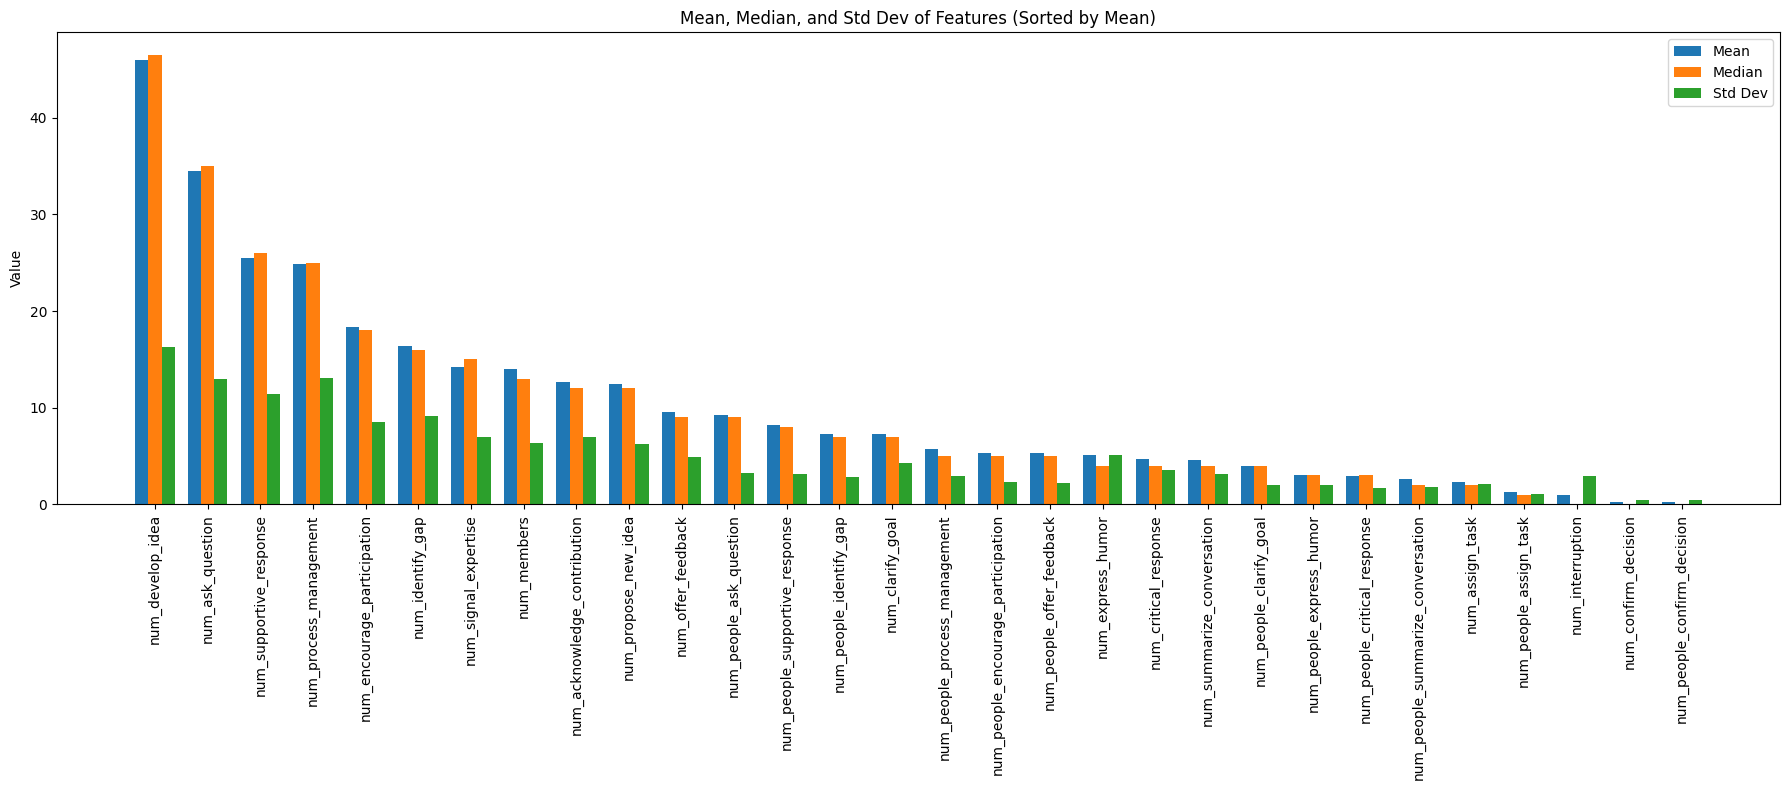

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams', 'meeting_length', 'time_screenshare']

# Select feature columns
feature_cols = [col for col in all_data_df.columns if col not in exclude]

# Calculate statistics
means = all_data_df[feature_cols].mean()
medians = all_data_df[feature_cols].median()
stds = all_data_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

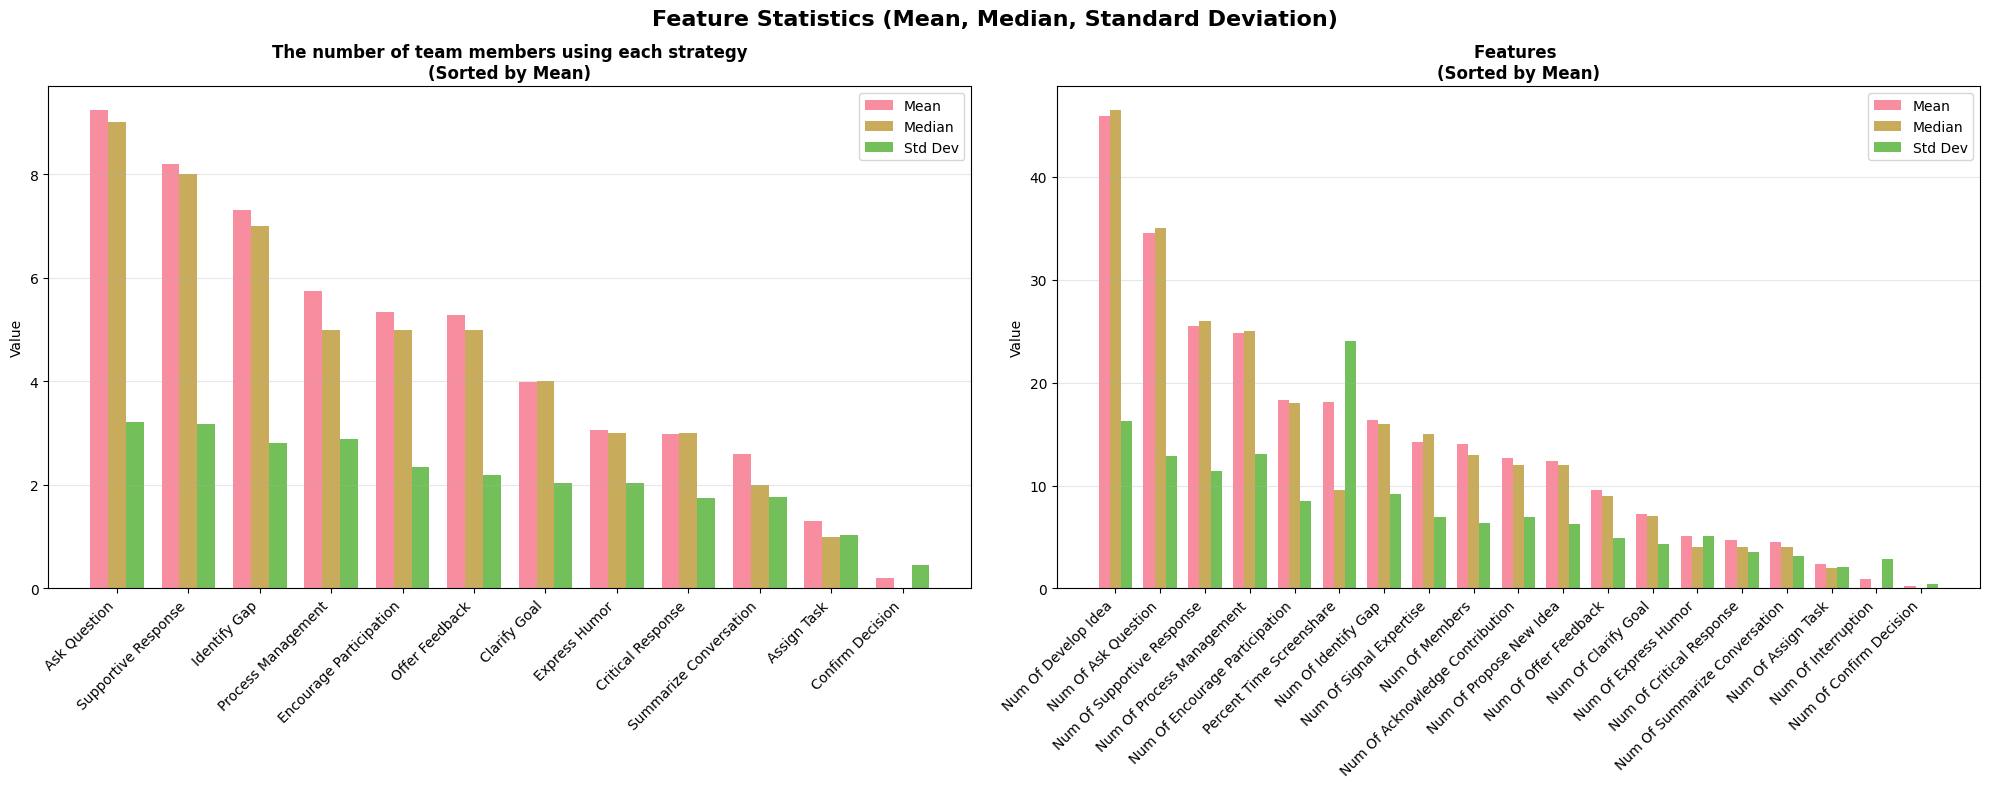

Features with 'people' in name (12):
  - num_people_ask_question
  - num_people_identify_gap
  - num_people_supportive_response
  - num_people_critical_response
  - num_people_offer_feedback
  - num_people_summarize_conversation
  - num_people_express_humor
  - num_people_encourage_participation
  - num_people_process_management
  - num_people_assign_task
  - num_people_clarify_goal
  - num_people_confirm_decision

Features without 'people' in name (19):
  - num_members
  - num_interruption
  - percent_time_screenshare
  - num_propose_new_idea
  - num_develop_idea
  - num_ask_question
  - num_signal_expertise
  - num_identify_gap
  - num_acknowledge_contribution
  - num_supportive_response
  - num_critical_response
  - num_offer_feedback
  - num_summarize_conversation
  - num_express_humor
  - num_encourage_participation
  - num_process_management
  - num_assign_task
  - num_clarify_goal
  - num_confirm_decision

SUMMARY STATISTICS

Features counting the number of people using a strate

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Columns to exclude

exclude = ['conference', 'session', 'num_teams', 'num_funded_teams', 'meeting_length']
# Also exclude any columns that end with '_numeric'
exclude.extend([col for col in all_data_df.columns if col.endswith('_numeric')])
# Select feature columns
feature_cols = [col for col in all_data_df.columns if col not in exclude]

# Separate features with 'people' in name and those without
people_features = [col for col in feature_cols if 'people' in col.lower()]
other_features = [col for col in feature_cols if 'people' not in col.lower()]

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Feature Statistics (Mean, Median, Standard Deviation)', fontsize=16, fontweight='bold')

# Plot 1: Features with 'people' in name
if people_features:
    # Calculate statistics
    means = all_data_df[people_features].mean()
    medians = all_data_df[people_features].median()
    stds = all_data_df[people_features].std()
    
    # Sort features by mean (descending)
    sorted_idx = means.sort_values(ascending=False).index
    means_sorted = means[sorted_idx]
    medians_sorted = medians[sorted_idx]
    stds_sorted = stds[sorted_idx]
    
    # Clean feature names for display
    feature_names = [col.replace('num_people_', '').replace('_', ' ').title() for col in sorted_idx]
    
    x = np.arange(len(people_features))
    width = 0.25
    
    ax1.bar(x - width, means_sorted, width, label='Mean', alpha=0.8)
    ax1.bar(x, medians_sorted, width, label='Median', alpha=0.8)
    ax1.bar(x + width, stds_sorted, width, label='Std Dev', alpha=0.8)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(feature_names, rotation=45, ha='right')
    ax1.set_ylabel('Value')
    ax1.set_title('The number of team members using each strategy\n(Sorted by Mean)', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No features with "people" found', 
            ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('The number of team members using each strategy\n(Sorted by Mean)')

# Plot 2: Features without 'people' in name
if other_features:
    # Calculate statistics
    means = all_data_df[other_features].mean()
    medians = all_data_df[other_features].median()
    stds = all_data_df[other_features].std()
    
    # Sort features by mean (descending)
    sorted_idx = means.sort_values(ascending=False).index
    means_sorted = means[sorted_idx]
    medians_sorted = medians[sorted_idx]
    stds_sorted = stds[sorted_idx]
    
    # Clean feature names for display
    feature_names = [col.replace('num_', 'num of ').replace('_', ' ').title() for col in sorted_idx]
    
    x = np.arange(len(other_features))
    width = 0.25
    
    ax2.bar(x - width, means_sorted, width, label='Mean', alpha=0.8)
    ax2.bar(x, medians_sorted, width, label='Median', alpha=0.8)
    ax2.bar(x + width, stds_sorted, width, label='Std Dev', alpha=0.8)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(feature_names, rotation=45, ha='right')
    ax2.set_ylabel('Value')
    ax2.set_title('Features \n(Sorted by Mean)', fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No features without "people" found', 
            ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Features')

plt.tight_layout()
plt.show()

# Print summary of what features are in each category
print(f"Features with 'people' in name ({len(people_features)}):")
for feature in people_features:
    print(f"  - {feature}")

print(f"\nFeatures without 'people' in name ({len(other_features)}):")
for feature in other_features:
    print(f"  - {feature}")

# Print summary statistics
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

if people_features:
    print(f"\nFeatures counting the number of people using a strategy:")
    print("-" * 40)
    people_stats = all_data_df[people_features].agg(['mean', 'median', 'std']).round(3)
    people_stats.columns = [col.replace('num_people_', '').replace('_', ' ').title() 
                           for col in people_stats.columns]
    print(people_stats.T)

if other_features:
    print(f"\nOther Features")
    print("-" * 40)
    other_stats = all_data_df[other_features].agg(['mean', 'median', 'std']).round(3)
    other_stats.columns = [col.replace('num_', '').replace('_', ' ').title() 
                          for col in other_stats.columns]
    print(other_stats.T)

In [30]:
print(all_data_df.columns)

Index(['conference', 'session', 'num_members', 'meeting_length',
       'num_interruption', 'percent_time_screenshare', 'num_propose_new_idea',
       'num_develop_idea', 'num_ask_question', 'num_signal_expertise',
       'num_identify_gap', 'num_acknowledge_contribution',
       'num_supportive_response', 'num_critical_response',
       'num_offer_feedback', 'num_summarize_conversation', 'num_express_humor',
       'num_encourage_participation', 'num_process_management',
       'num_assign_task', 'num_clarify_goal', 'num_confirm_decision',
       'num_people_ask_question', 'num_people_identify_gap',
       'num_people_supportive_response', 'num_people_critical_response',
       'num_people_offer_feedback', 'num_people_summarize_conversation',
       'num_people_express_humor', 'num_people_encourage_participation',
       'num_people_process_management', 'num_people_assign_task',
       'num_people_clarify_goal', 'num_people_confirm_decision', 'num_teams',
       'num_funded_teams', 'n

### Visualize individual sessions

In [ ]:
# Read the JSON data
file_path = '/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S5.json'

2021_09_30_MZT_S5


In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import numpy as np
import os
import re
import urllib.parse

def safe_file_path(path):
    # Split the path into directory and filename
    directory = os.path.dirname(path)
    filename = os.path.basename(path)
    # URL encode the filename to handle special characters
    safe_filename = urllib.parse.quote(filename, safe='')
    # Rejoin the path
    return os.path.join(directory, safe_filename)

def analyze_meeting(file_path):
# Safely handle the file path

    conf_name = file_path.split('/')[-1].split('.')[0]
    print(conf_name)
    # Use the safe file path
    safe_path = safe_file_path(file_path)

    with open(safe_path, 'r') as f:
        data = json.load(f)

    # Extract just the base filename without path and extension
    file_name = os.path.basename(file_path)
    file_name = os.path.splitext(file_name)[0]  # Remove extension

    # Extract annotations
    all_annotations = []
    data = data['all_data']
    for entry in data:
        if 'annotations' in entry:
            if isinstance(entry['annotations'], dict):
                all_annotations.extend(entry['annotations'].keys())
            elif isinstance(entry['annotations'], list):
                all_annotations.extend(entry['annotations'])

    # remove 'None' from all_annotations
    all_annotations = [annotation for annotation in all_annotations if annotation != 'None']

    def normalize_annotation(annotation):
        # Replace underscores with spaces and convert to lowercase
        normalized = re.sub(r'_', ' ', annotation.lower()).strip()
        
        return normalized

    # Create a mapping of normalized forms to all their original forms
    normalized_to_originals = defaultdict(list)
    for annotation in all_annotations:
        normalized = normalize_annotation(annotation)
        normalized_to_originals[normalized].append(annotation)

    # Choose the most common original form for each normalized form
    normalized_to_preferred = {}
    for normalized, originals in normalized_to_originals.items():
        # Count occurrences of each original form
        original_counts = Counter(originals)
        # Choose the most common one (or the first if tied)
        preferred = max(original_counts.items(), key=lambda x: (x[1], len(x[0])))[0]
        normalized_to_preferred[normalized] = preferred

    # Count normalized annotations
    normalized_counts = Counter(normalize_annotation(a) for a in all_annotations)

    # Create a DataFrame with normalized counts and preferred original names
    annotation_df = pd.DataFrame({
        'normalized_name': list(normalized_counts.keys()),
        'count': list(normalized_counts.values()),
        'original_name': [normalized_to_preferred[n] for n in normalized_counts.keys()]
    })

    # Sort by count
    annotation_df = annotation_df.sort_values('count', ascending=True)

    # Calculate speaking time per speaker
    speaker_times = defaultdict(int)
    for entry in data:
        speaker_times[entry['speaker']] += int(entry['speaking_duration'])

    # Create turn taking sequence
    turn_sequence = [entry['speaker'] for entry in data]

    # Set the style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")

    # 1. Annotation counts - Separate full-size plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=annotation_df, x='count', y='original_name')
    plt.title(f'Annotation Types and Their Frequencies for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Annotation Type', fontsize=12)
    plt.tight_layout()
    plt.show()  
    # plt.savefig(f'annotation_counts_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Speaking time per speaker - Separate full-size plot
    plt.figure(figsize=(12, 8))
    speaker_df = pd.DataFrame.from_dict(speaker_times, orient='index', columns=['duration'])
    speaker_df = speaker_df.sort_values('duration', ascending=True)
    sns.barplot(data=speaker_df.reset_index(), x='duration', y='index')
    plt.title(f'Total Speaking Duration by Speaker for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Duration (seconds)', fontsize=12)
    plt.ylabel('Speaker', fontsize=12)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'speaking_duration_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Turn taking pattern - Separate full-size plot
    plt.figure(figsize=(14, 8))
    unique_speakers = list(set(turn_sequence))
    y_positions = range(len(unique_speakers))
    speaker_to_y = dict(zip(unique_speakers, y_positions))
    x_positions = range(len(turn_sequence))
    y_values = [speaker_to_y[speaker] for speaker in turn_sequence]

    plt.plot(x_positions, y_values, 'o-', linewidth=1.5, markersize=8)
    plt.yticks(y_positions, unique_speakers)
    plt.title(f'Turn Taking Pattern Over Time for {conf_name}', fontsize=14, pad=20)
    plt.xlabel('Turn Sequence', fontsize=12)
    plt.ylabel('Speaker', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'turn_taking_{file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Timeline visualization of annotations - New visualization
    plt.figure(figsize=(16, 10))

    # Prepare data for timeline visualization
    timeline_data = []
    colors = plt.cm.Set3(np.linspace(0, 1, len(normalized_counts)))

    # Convert time strings to seconds for x-axis
    def time_to_seconds(time_str):
        """Convert time string like '00:01' to seconds"""
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds

    # Collect all annotation occurrences with their timing
    for entry in data:
        if 'annotations' in entry and entry['annotations']:
            start_time = time_to_seconds(entry['start_time'])
            end_time = time_to_seconds(entry['end_time'])
            duration = end_time - start_time
            
            for annotation in entry['annotations'].keys():
                if annotation != 'None':
                    normalized_annotation = normalize_annotation(annotation)
                    timeline_data.append({
                        'annotation': normalized_annotation,
                        'start_time': start_time,
                        'end_time': end_time,
                        'duration': duration
                    })

    # Create DataFrame for timeline
    timeline_df = pd.DataFrame(timeline_data)

    if not timeline_df.empty:
        # Get unique annotations and assign colors
        unique_annotations = timeline_df['annotation'].unique()
        annotation_to_color = dict(zip(unique_annotations, colors[:len(unique_annotations)]))
        
        # Create the timeline plot
        y_positions = range(len(unique_annotations))
        annotation_to_y = dict(zip(unique_annotations, y_positions))
        
        # Plot horizontal bars for each annotation occurrence
        for _, row in timeline_df.iterrows():
            annotation = row['annotation']
            start_time = row['start_time']
            duration = row['duration']
            y_pos = annotation_to_y[annotation]
            color = annotation_to_color[annotation]
            
            plt.barh(y_pos, duration, left=start_time, height=0.6, 
                    color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Customize the plot
        plt.yticks(y_positions, unique_annotations)
        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('Annotation Types', fontsize=12)
        plt.title(f'Timeline of Annotation Occurrences During Meeting for {conf_name}', fontsize=14, pad=20)
        plt.grid(True, alpha=0.3, axis='x')
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=annotation_to_color[ann], 
                                    edgecolor='black', linewidth=0.5, label=ann) 
                        for ann in unique_annotations]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        # plt.savefig(f'annotation_timeline_{file_name}.png', dpi=300, bbox_inches='tight')
        plt.close()
    else:
        print("No annotation data found for timeline visualization")
        plt.close()



2021_09_30_MZT_S5


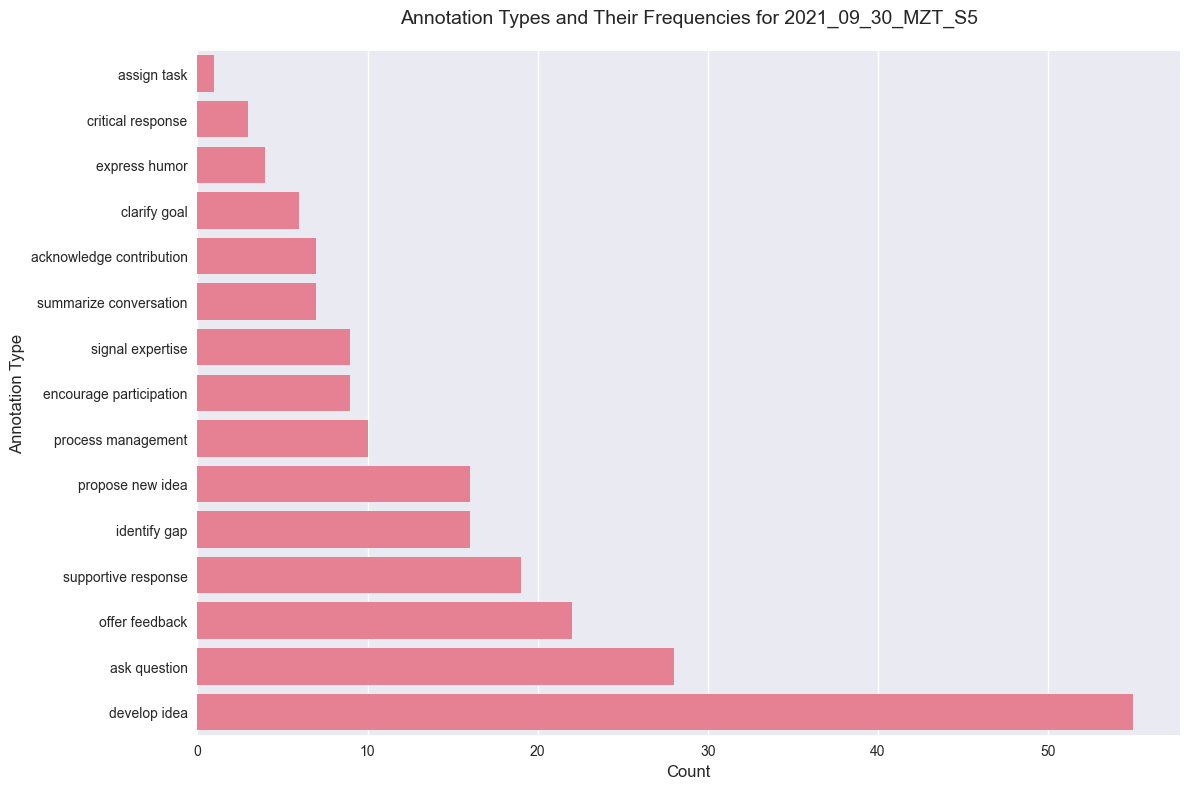

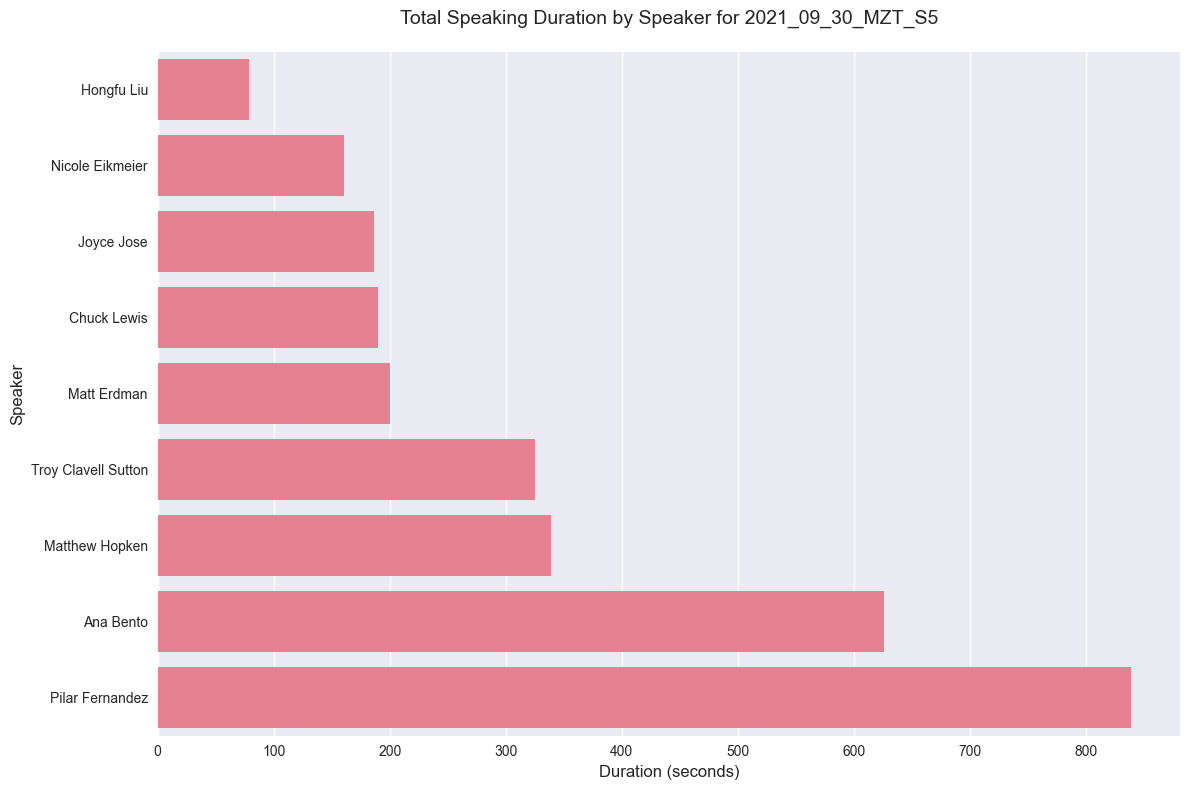

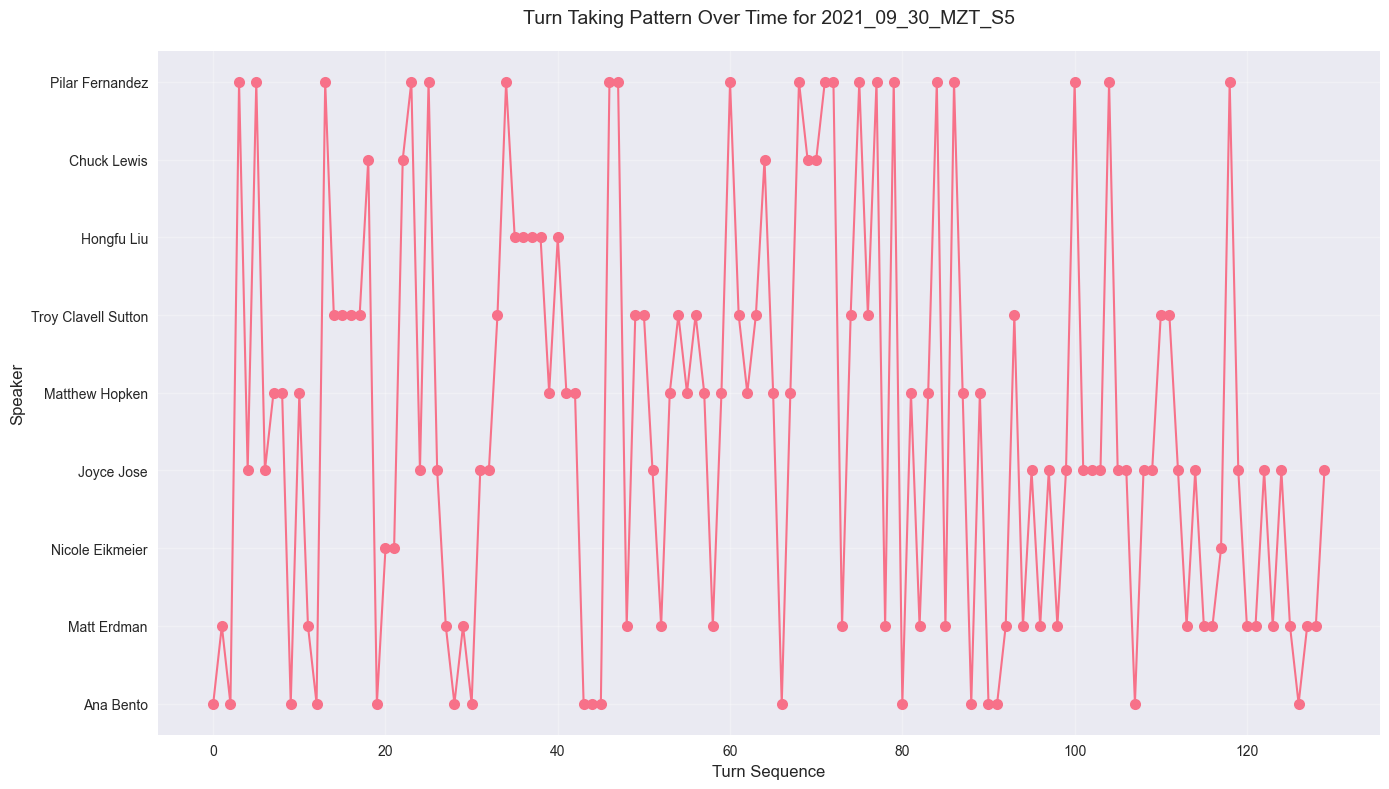

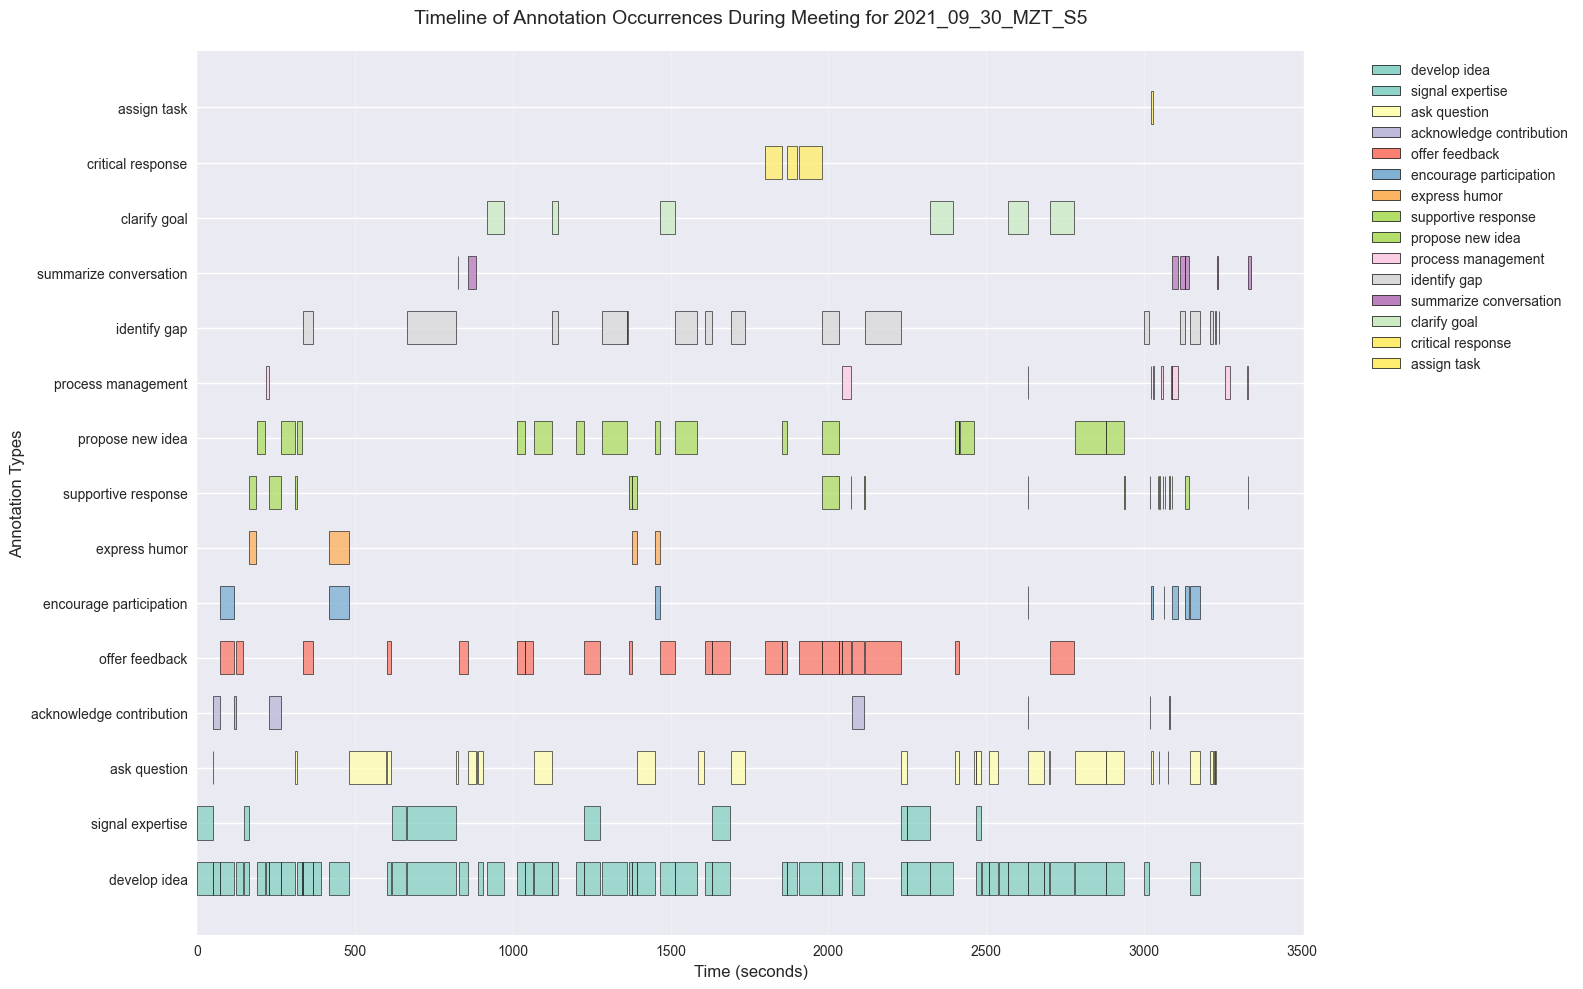

In [12]:
analyze_meeting(file_path)

2021_09_30_MZT_S7


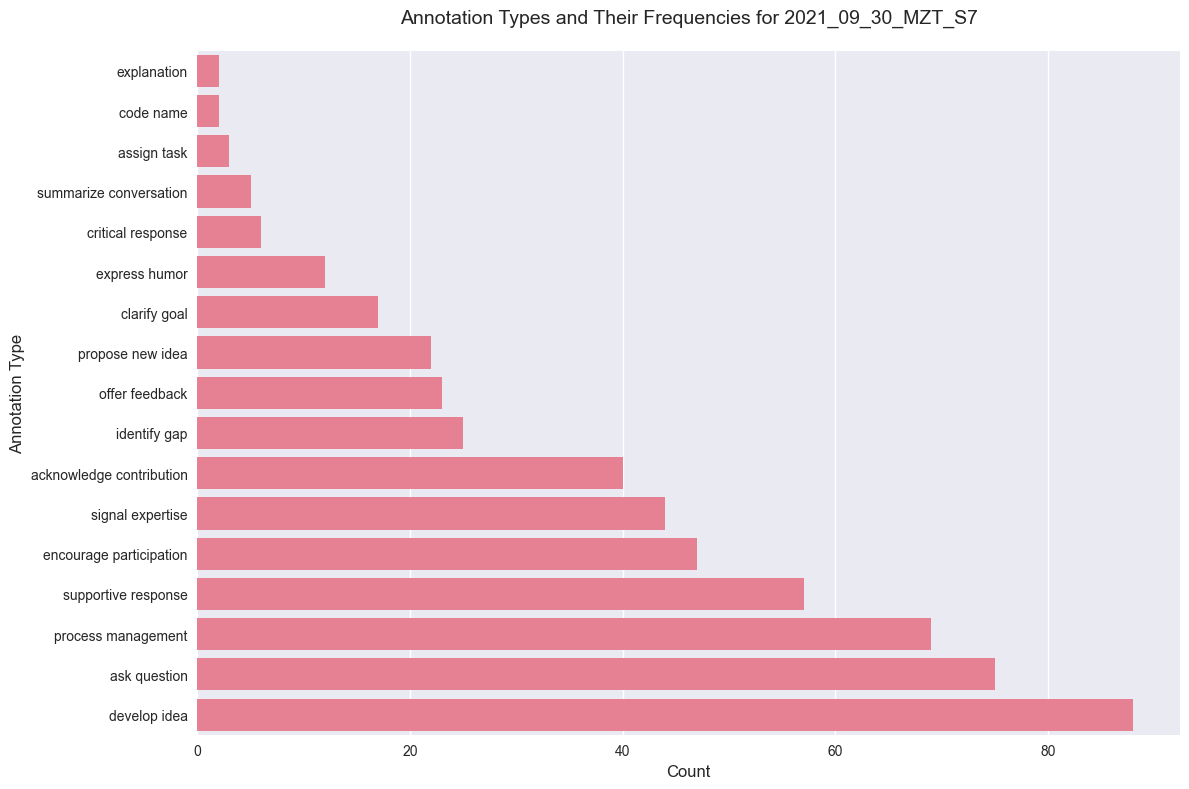

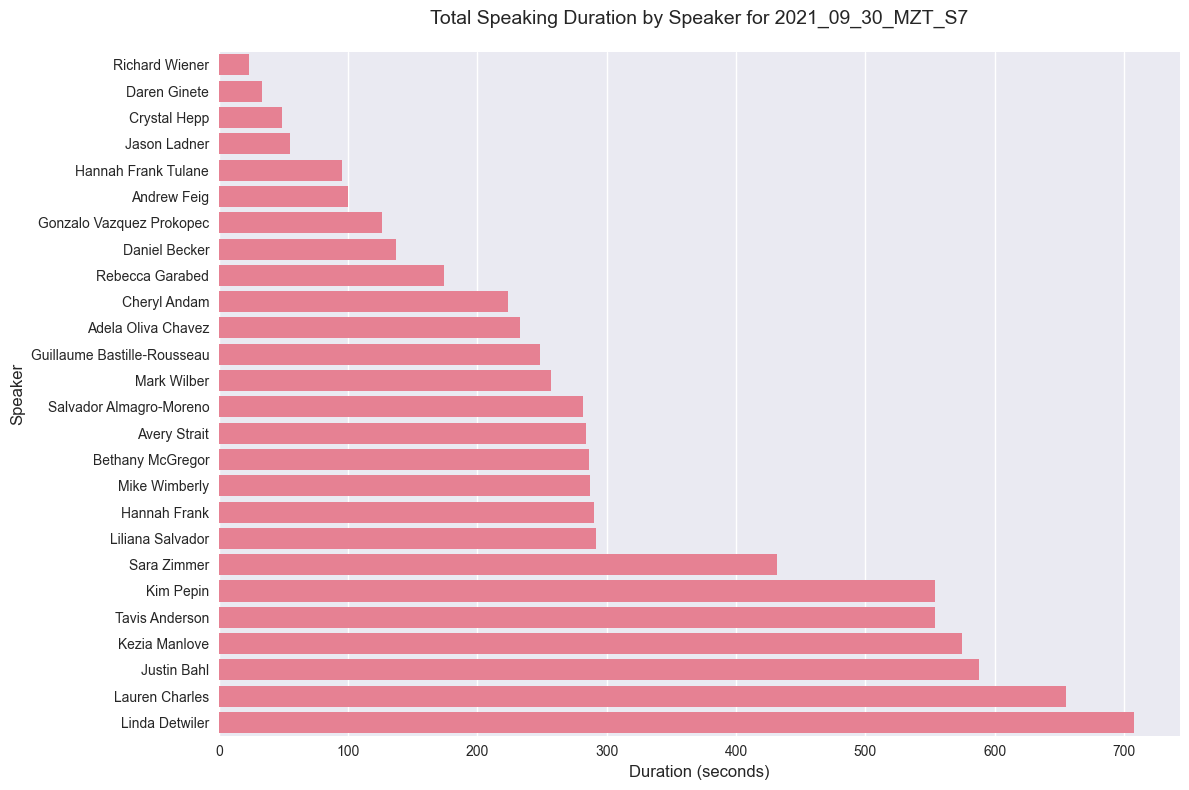

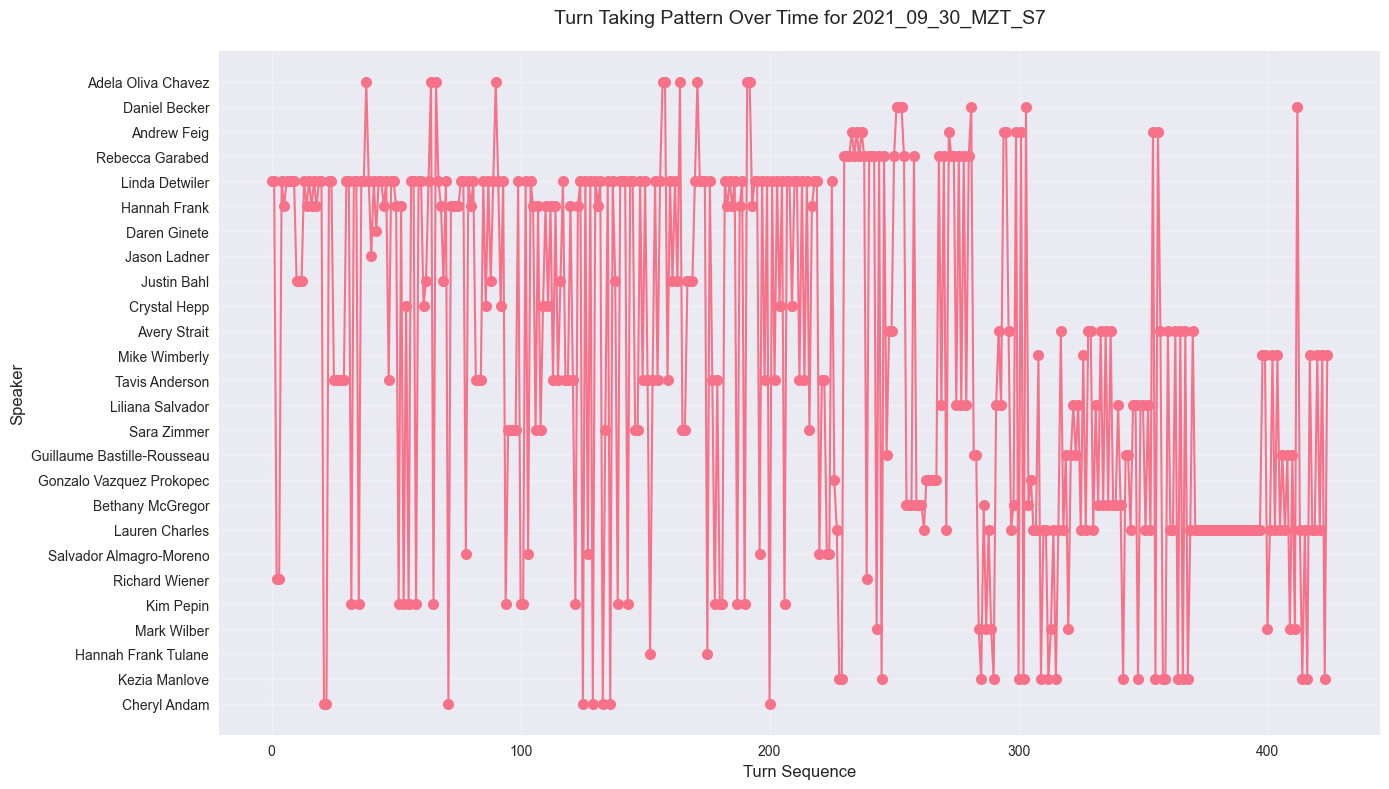

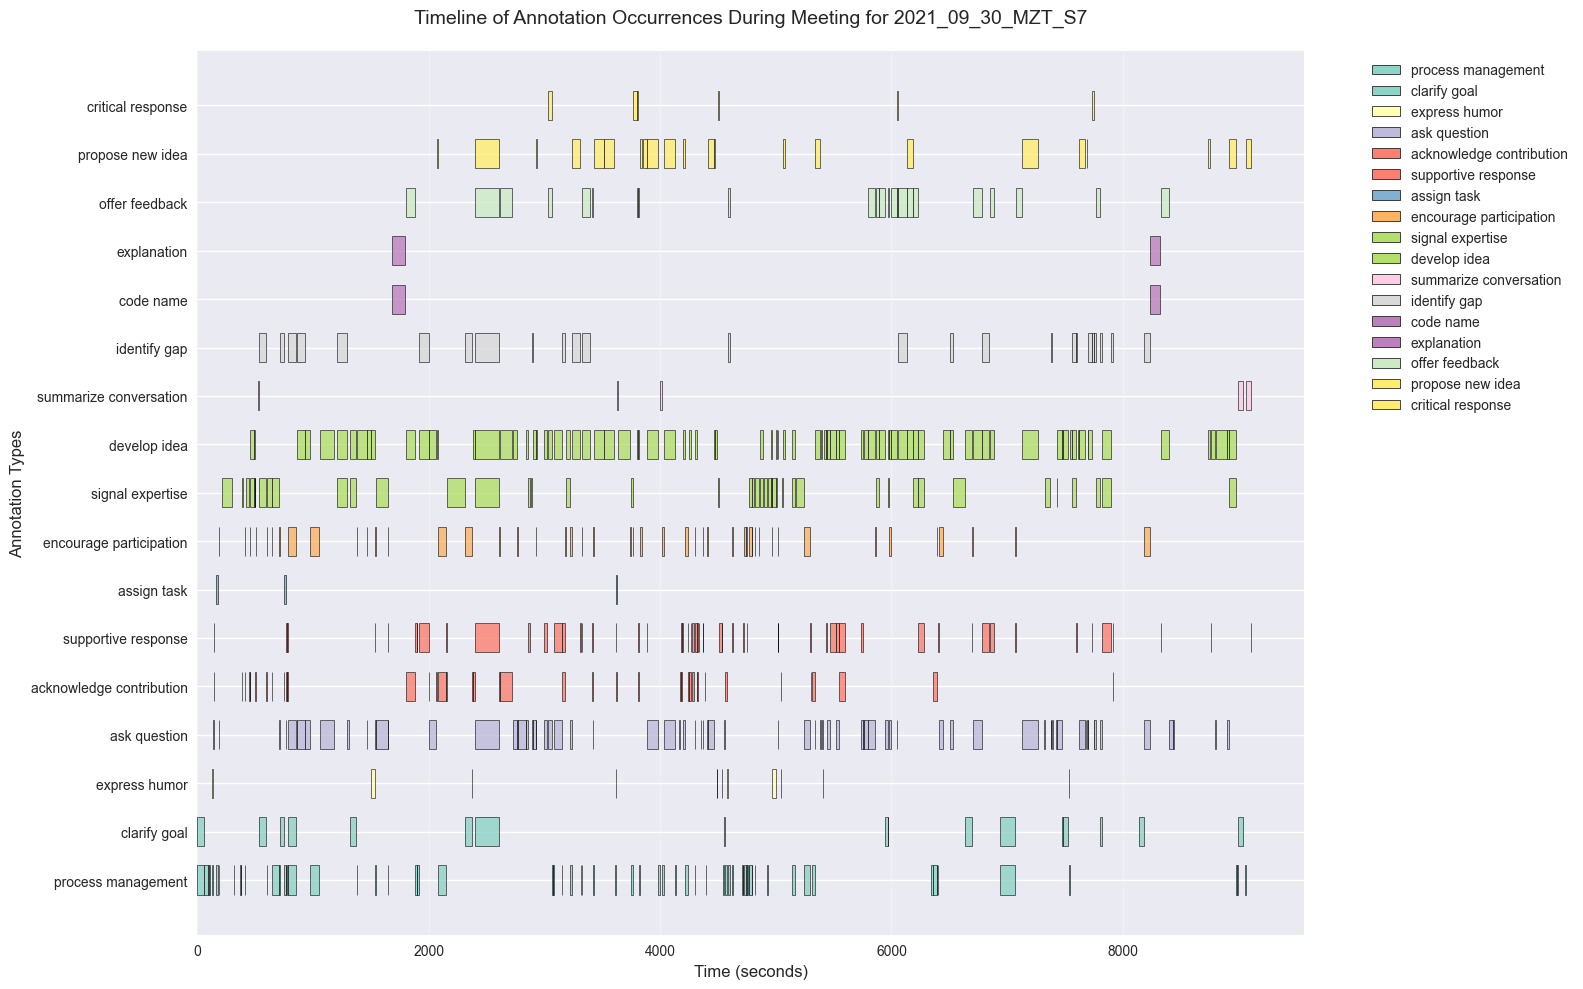

In [14]:
file_path='/Users/eveyhuang/Documents/NICO/gemini_code/data/2021MZT/session_data/2021_09_30_MZT_S7.json'
analyze_meeting(file_path)

### Normalize features

In [36]:
## NORMALIZE features

from sklearn.preprocessing import StandardScaler

# Columns to exclude from normalization
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Columns to normalize
normalize_columns = [col for col in all_data_df.columns if col not in exclude_columns]

# Fill missing values for normalization
all_data_df_filled = all_data_df.copy()
all_data_df_filled[normalize_columns] = all_data_df_filled[normalize_columns].fillna(0)

# Normalize selected columns
scaler = StandardScaler()
normalized_values = scaler.fit_transform(all_data_df_filled[normalize_columns])

# Create normalized DataFrame
normalized_df = pd.DataFrame(normalized_values, columns=normalize_columns, index=all_data_df.index)

# Combine with excluded columns (keep original values)
for col in exclude_columns:
    normalized_df[col] = all_data_df[col]

# Reorder columns to match original DataFrame
normalized_df = normalized_df[exclude_columns + normalize_columns]

print(normalized_df.head())

  conference             session  num_teams  num_funded_teams  num_members  \
0    2020NES   2020_11_05_NES_S6          2                 0    -0.792630   
1    2020NES   2020_11_06_NES_S1          2                 1    -0.478797   
2    2020NES  2020_11_06_NES_S10          0                 0    -0.478797   
3    2020NES   2020_11_06_NES_S7          2                 0    -0.321880   
4    2020NES   2020_11_05_NES_S1          1                 0    -0.164964   

   meeting_length  num_interruption  percent_time_screenshare  \
0       -2.402382         -0.334146                  3.413476   
1       -1.389008         -0.334146                 -0.757259   
2       -0.986170          0.360878                  3.413476   
3       -1.412193         -0.334146                 -0.757259   
4       -1.054759          0.360878                 -0.757259   

   num_propose_new_idea  num_develop_idea  ...  \
0             -1.344224         -2.213254  ...   
1              0.252874         -0.73564

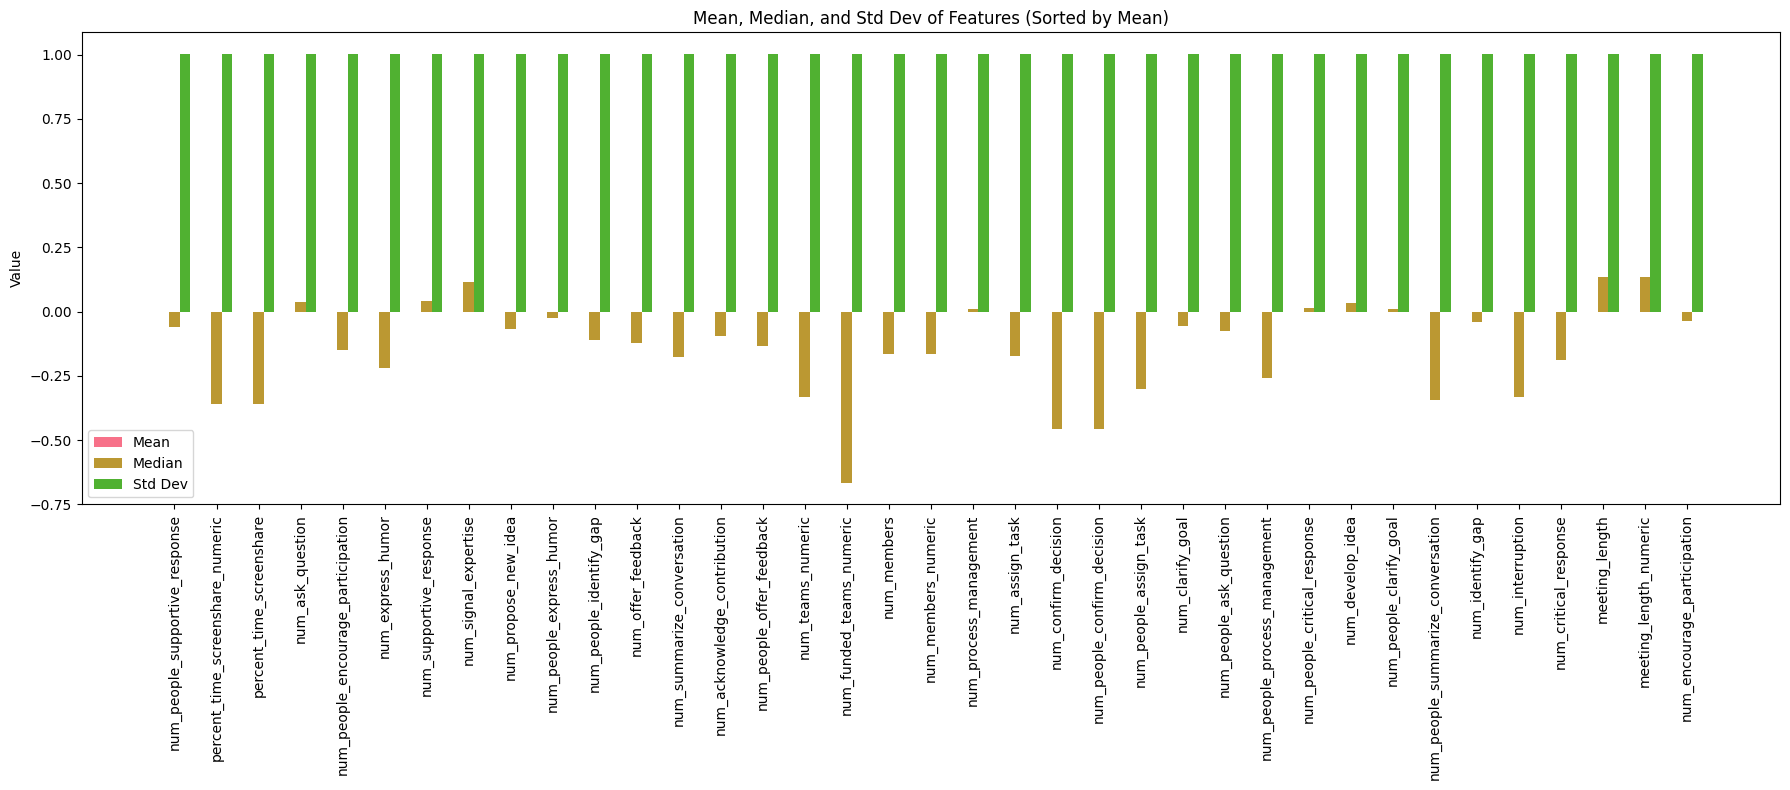

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Columns to exclude
exclude = ['conference', 'session', 'num_teams', 'num_funded_teams']

# Select feature columns
feature_cols = [col for col in normalized_df.columns if col not in exclude]

# Calculate statistics
means = normalized_df[feature_cols].mean()
medians = normalized_df[feature_cols].median()
stds = normalized_df[feature_cols].std()

# Sort features by mean (descending)
sorted_idx = means.sort_values(ascending=False).index
means_sorted = means[sorted_idx]
medians_sorted = medians[sorted_idx]
stds_sorted = stds[sorted_idx]

x = np.arange(len(feature_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, means_sorted, width, label='Mean')
ax.bar(x, medians_sorted, width, label='Median')
ax.bar(x + width, stds_sorted, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(sorted_idx, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (Sorted by Mean)')
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
normalized_df.to_excel('normalized_all_data_df.xlsx', index=False)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


def normalize_features(df):
    """
    Normalize features using StandardScaler and return both original and normalized data.
    """
    # Identify feature columns (exclude metadata columns)
    exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 
                      'has_teams', 'has_funded_teams']
    
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Select only numeric features
    numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Found {len(numeric_features)} numeric features for normalization")
    
    # Handle missing values
    df_clean = df[numeric_features].fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_clean)
    
    # Create DataFrame with normalized features
    df_normalized = pd.DataFrame(normalized_features, 
                                columns=numeric_features, 
                                index=df.index)
    
    return df_normalized, numeric_features, scaler

### logstic regression (use normalized_df)

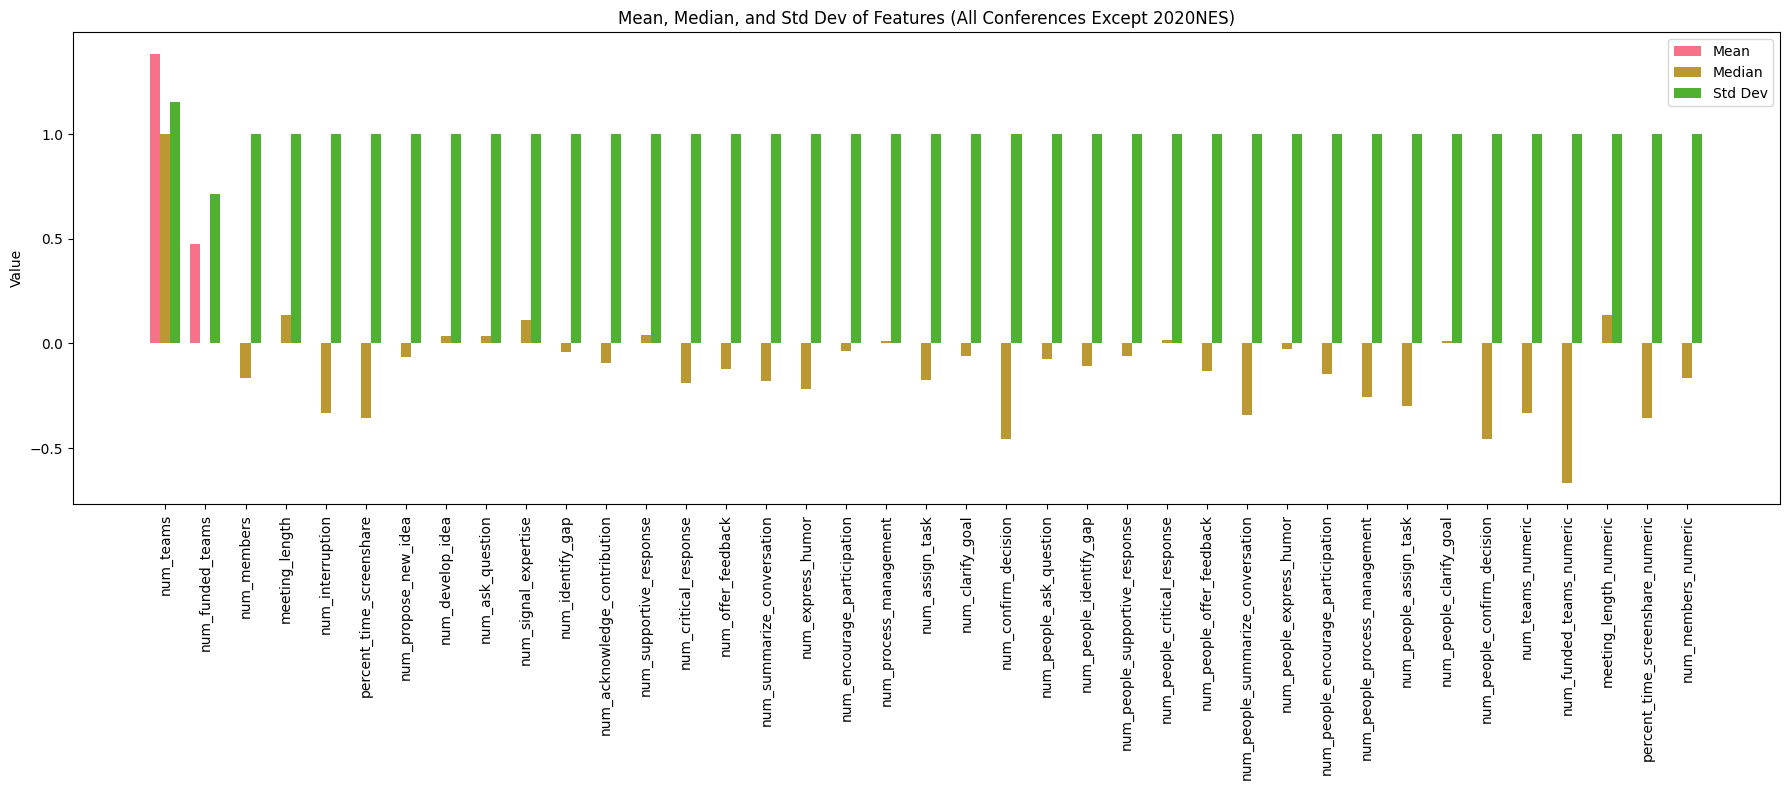

In [39]:
import numpy as np
import matplotlib.pyplot as plt



# Exclude non-numeric columns except 'conference'
numeric_cols = normalized_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean, median, std for each column (across all data)
mean_vals = normalized_df[numeric_cols].mean()
median_vals = normalized_df[numeric_cols].median()
std_vals = normalized_df[numeric_cols].std()

# Plotting
x = np.arange(len(numeric_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, mean_vals, width, label='Mean')
ax.bar(x, median_vals, width, label='Median')
ax.bar(x + width, std_vals, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (All Conferences Except 2020NES)')
ax.legend()
plt.tight_layout()
plt.show()


In [40]:
# Check your data distribution
print("Distribution of num_teams:")
print(normalized_df['num_teams'].value_counts().sort_index())

print("\nDistribution of num_funded_teams:")
print(normalized_df['num_funded_teams'].value_counts().sort_index())

Distribution of num_teams:
num_teams
0    39
1    48
2    45
3    22
4     1
8     1
Name: count, dtype: int64

Distribution of num_funded_teams:
num_funded_teams
0    96
1    49
2    10
5     1
Name: count, dtype: int64


In [41]:
# Create binary versions

normalized_df['has_teams'] = (normalized_df['num_teams'] > 0).astype(int)
normalized_df['has_funded_teams'] = (normalized_df['num_funded_teams'] > 0).astype(int)

print("Binary target distributions:")
print("has_teams:")
print(normalized_df['has_teams'].value_counts().sort_index())
print("\nhas_funded_teams:")
print(normalized_df['has_funded_teams'].value_counts().sort_index())

Binary target distributions:
has_teams:
has_teams
0     39
1    117
Name: count, dtype: int64

has_funded_teams:
has_funded_teams
0    96
1    60
Name: count, dtype: int64


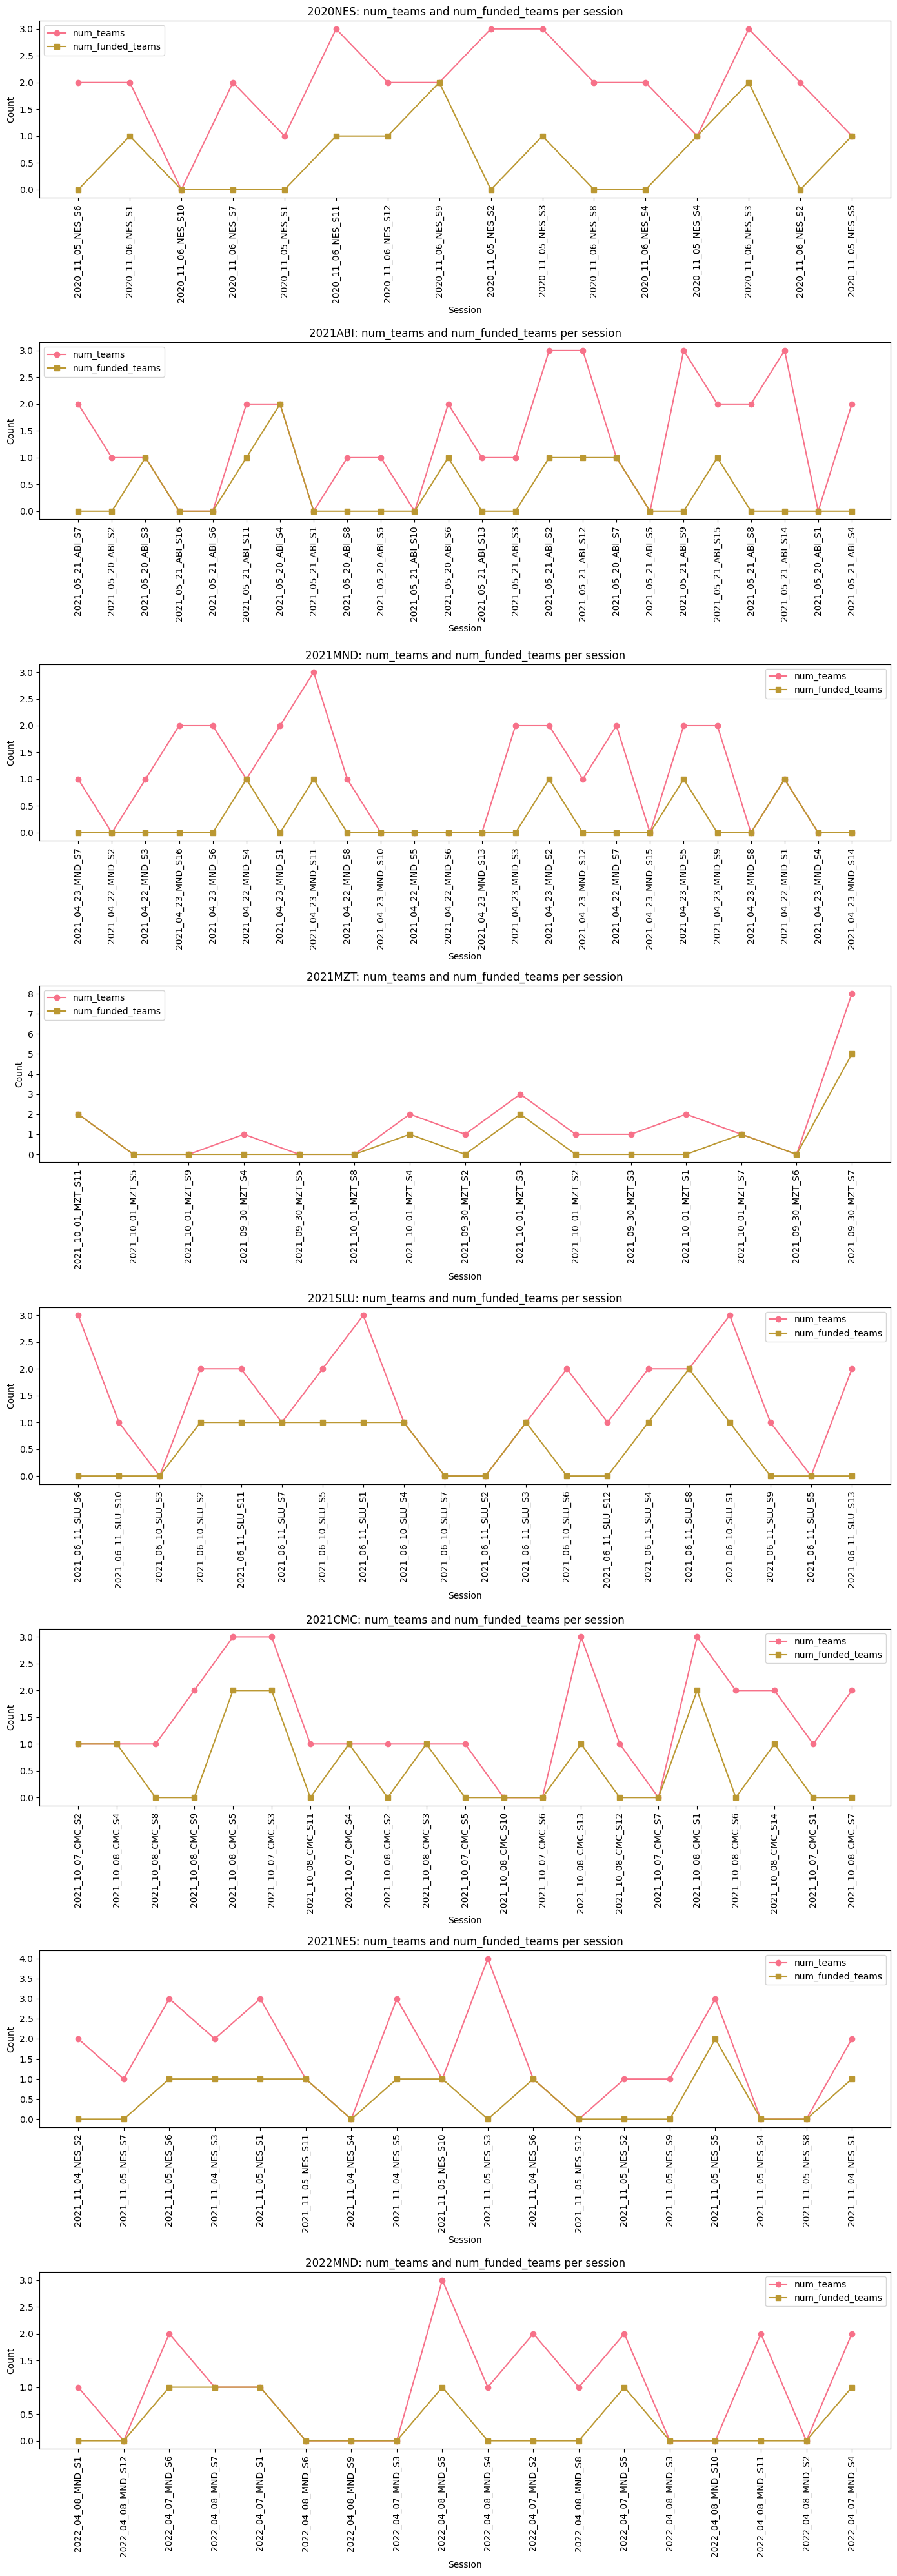

In [42]:
import matplotlib.pyplot as plt

# Get unique conferences
unique_conferences = normalized_df['conference'].unique()

fig, axes = plt.subplots(len(unique_conferences), 1, figsize=(14, 5 * len(unique_conferences)), sharex=False)

if len(unique_conferences) == 1:
    axes = [axes]  # Ensure axes is always iterable

for idx, conf in enumerate(unique_conferences):
    conf_df = normalized_df[normalized_df['conference'] == conf]
    sessions = conf_df['session']
    num_teams = conf_df['num_teams']
    num_funded_teams = conf_df['num_funded_teams']

    ax = axes[idx]
    ax.plot(sessions, num_teams, marker='o', label='num_teams')
    ax.plot(sessions, num_funded_teams, marker='s', label='num_funded_teams')
    ax.set_title(f"{conf}: num_teams and num_funded_teams per session")
    ax.set_xlabel("Session")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xticks(range(len(sessions)))
    ax.set_xticklabels(sessions, rotation=90)

plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Columns to exclude from multicollinearity analysis
exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']
exclude_columns.extend([col for col in all_data_df.columns if col.endswith('_numeric')])
# Select only feature columns
feature_columns = [col for col in normalized_df.columns if col not in exclude_columns]

# Compute correlation matrix
corr_matrix = normalized_df[feature_columns].corr()

# Find pairs with high absolute correlation (> 0.8)
high_corr_pairs = []
threshold = 0.8
for i in range(len(feature_columns)):
    for j in range(i+1, len(feature_columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append((feature_columns[i], feature_columns[j], corr_val))

print("Highly correlated feature pairs (|correlation| > 0.8):")
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} <-> {f2}: correlation = {corr_val:.3f}")

# Calculate Variance Inflation Factor (VIF)

X = normalized_df[feature_columns].values
vif_data = pd.DataFrame({
    'feature': feature_columns,
    'VIF': [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

# Report features with VIF > 5 (commonly considered problematic)
problematic_vif = vif_data[vif_data['VIF'] > 5]
if not problematic_vif.empty:
    print("\nFeatures with VIF > 5 (potential multicollinearity):")
    print(problematic_vif.sort_values('VIF', ascending=False).to_string(index=False))
else:
    print("\nNo features with VIF > 5 detected.")

Highly correlated feature pairs (|correlation| > 0.8):
num_critical_response <-> num_people_critical_response: correlation = 0.871
num_offer_feedback <-> num_people_offer_feedback: correlation = 0.804
num_confirm_decision <-> num_people_confirm_decision: correlation = 1.000

Variance Inflation Factor (VIF) for each feature:
                           feature      VIF
       num_people_confirm_decision      inf
              num_confirm_decision      inf
    num_people_supportive_response 6.629841
                    meeting_length 6.498910
            num_process_management 6.489837
             num_critical_response 6.077560
                       num_members 5.826516
           num_people_ask_question 5.746101
                  num_develop_idea 5.729243
      num_people_critical_response 5.671870
                  num_clarify_goal 4.860183
           num_people_identify_gap 4.697805
         num_people_offer_feedback 4.605753
                num_offer_feedback 4.443395
     num_peopl

In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def normalize_and_run_logistic_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Normalize features and run logistic regression.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data WITHOUT stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state  # Removed stratify=y
    )
    
    # Rest of the function remains the same...
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"Logistic Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df
# Usage example:
# model, scaler, importance, X_train_scaled, X_test_scaled = normalize_and_run_logistic_regression(all_data, 'num_funded_teams')

In [ ]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

def run_logistic_regression_with_stats_robust(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run logistic regression with robust handling of multicollinearity and perfect separation.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams', 'meeting_length', 'num_members'] and not col.endswith('_numeric')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Remove low variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var_selected = variance_selector.fit_transform(X_train)
    X_test_var_selected = variance_selector.transform(X_test)
    
    # Get selected feature names
    selected_features = [feature_columns[i] for i in range(len(feature_columns)) 
                        if variance_selector.get_support()[i]]
    
    print(f"Original features: {len(feature_columns)}")
    print(f"Features after variance threshold: {len(selected_features)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_var_selected)
    X_test_scaled = scaler.transform(X_test_var_selected)
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train_scaled)
    X_test_with_const = sm.add_constant(X_test_scaled)
    
    # Try different fitting methods
    methods_to_try = ['newton', 'bfgs', 'lbfgs', 'powell', 'cg']
    results = None
    
    for method in methods_to_try:
        try:
            print(f"Trying method: {method}")
            model = sm.Logit(y_train, X_train_with_const)
            results = model.fit(method=method, maxiter=1000, disp=0)
            print(f"Success with method: {method}")
            break
        except Exception as e:
            print(f"Method {method} failed: {str(e)[:100]}...")
            continue
    
    if results is None:
        print("All methods failed. Trying with regularization...")
        # Use sklearn with regularization as fallback
        from sklearn.linear_model import LogisticRegression 
        sklearn_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=random_state)
        sklearn_model.fit(X_train_scaled, y_train)
        
        # Create a mock results object for reporting
        class MockResults:
            def __init__(self, model, feature_names):
                self.params = np.concatenate([[0], model.coef_[0]])  # Add intercept
                self.pvalues = np.ones(len(self.params))  # Placeholder p-values
                self.bse = np.ones(len(self.params)) * 0.1  # Placeholder std errors
                self.tvalues = self.params / self.bse
                self.summary = lambda: print("Using sklearn with L2 regularization (no p-values available)")
        
        results = MockResults(sklearn_model, selected_features)
        y_pred_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]
        y_pred = sklearn_model.predict(X_test_scaled)
    else:
        # Get predictions for sklearn metrics
        y_pred_proba = results.predict(X_test_with_const)
        y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Accuracy: {(y_pred == y_test).mean():.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    try:
        print(results.summary())
    except:
        print("Summary not available (using sklearn fallback)")
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + selected_features
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    z_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        'z_score': z_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features significant at p < 0.05")
    
    return results, results_df, scaler, selected_features

In [47]:
def visualize_logistic_features(df, target_column, top_n=10, save_plots=False):
    """
    Create comprehensive visualizations of logistic regression feature importance.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    top_n : int
        Number of top features to show in plots
    save_plots : bool
        Whether to save plots to files
    """
    
    print(f"Running logistic regression for target: {target_column}")
    print("=" * 60)
    
    # Run logistic regression
    results, coef_df, scaler, selected_features = run_logistic_regression_with_stats_robust(df, target_column)
    
    # Remove intercept for visualization
    feature_df = coef_df[coef_df['feature'] != 'intercept'].copy()
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Coefficient Magnitude Plot (Top N features)
    plt.subplot(2, 3, 1)
    top_features = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Most Predictive Features\n(Red=Negative, Blue=Positive)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add coefficient values on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['coefficient'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{coef:.3f}', va='center', fontsize=9)
    
    # 2. Coefficient Direction Plot
    plt.subplot(2, 3, 2)
    top_features_signed = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features_signed['coefficient']]
    bars = plt.barh(range(len(top_features_signed)), top_features_signed['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features_signed)), top_features_signed['feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Feature Effects on {target_column}\n(Red=Decreases, Blue=Increases)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Statistical Significance Plot (if available)
    plt.subplot(2, 3, 3)
    if not feature_df['p_value'].isna().all():
        significant_features = feature_df[feature_df['p_value'] < 0.05].nlargest(top_n, 'abs_coefficient')
        if len(significant_features) > 0:
            colors = ['red' if x < 0 else 'blue' for x in significant_features['coefficient']]
            bars = plt.barh(range(len(significant_features)), significant_features['abs_coefficient'], color=colors, alpha=0.7)
            
            plt.yticks(range(len(significant_features)), significant_features['feature'], fontsize=10)
            plt.xlabel('Absolute Coefficient Value', fontsize=12)
            plt.title(f'Statistically Significant Features\n(p < 0.05)', fontsize=14, fontweight='bold')
            plt.grid(axis='x', alpha=0.3)
            
            # Add p-values on bars
            for i, (bar, p_val) in enumerate(zip(bars, significant_features['p_value'])):
                plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'p={p_val:.3f}', va='center', fontsize=9)
        else:
            plt.text(0.5, 0.5, 'No significant features\n(p < 0.05)', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Statistically Significant Features', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Statistical Significance', fontsize=14, fontweight='bold')
    
    # 4. Coefficient vs P-value Scatter Plot (if available)
    plt.subplot(2, 3, 4)
    if not feature_df['p_value'].isna().all():
        plt.scatter(feature_df['coefficient'], -np.log10(feature_df['p_value']), alpha=0.6, s=50)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
        plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Label top features
        top_features_scatter = feature_df.nlargest(5, 'abs_coefficient')
        for _, row in top_features_scatter.iterrows():
            plt.annotate(row['feature'], (row['coefficient'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
    

    
    # 5. Coefficient Distribution
    plt.subplot(2, 3, 5)
    plt.hist(feature_df['coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero effect')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'logistic_regression_features_{target_column}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: logistic_regression_features_{target_column}.png")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    print(f"Total features analyzed: {len(feature_df)}")
    print(f"Positive coefficients: {len(feature_df[feature_df['coefficient'] > 0])}")
    print(f"Negative coefficients: {len(feature_df[feature_df['coefficient'] < 0])}")
    
    if not feature_df['p_value'].isna().all():
        significant_count = len(feature_df[feature_df['p_value'] < 0.05])
        print(f"Statistically significant (p < 0.05): {significant_count}")
        print(f"Highly significant (p < 0.01): {len(feature_df[feature_df['p_value'] < 0.01])}")
    
    print(f"Mean absolute coefficient: {feature_df['abs_coefficient'].mean():.4f}")
    print(f"Max absolute coefficient: {feature_df['abs_coefficient'].max():.4f}")
    
    return results, coef_df, scaler, selected_features

Running logistic regression for target: has_teams
Original features: 32
Features after variance threshold: 32
Trying method: newton
Success with method: newton

Logistic Regression Results for has_teams
Training samples: 124
Test samples: 32
ROC AUC: 0.589
Accuracy: 0.688

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:              has_teams   No. Observations:                  124
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                           31
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.5912
Time:                        17:17:03   Log-Likelihood:                -28.509
converged:                       True   LL-Null:                       -69.730
Covariance Type:            nonrobust   LLR p-value:                 1.488e-06
                 coef    std err          z      P>|z|      [0.025      0

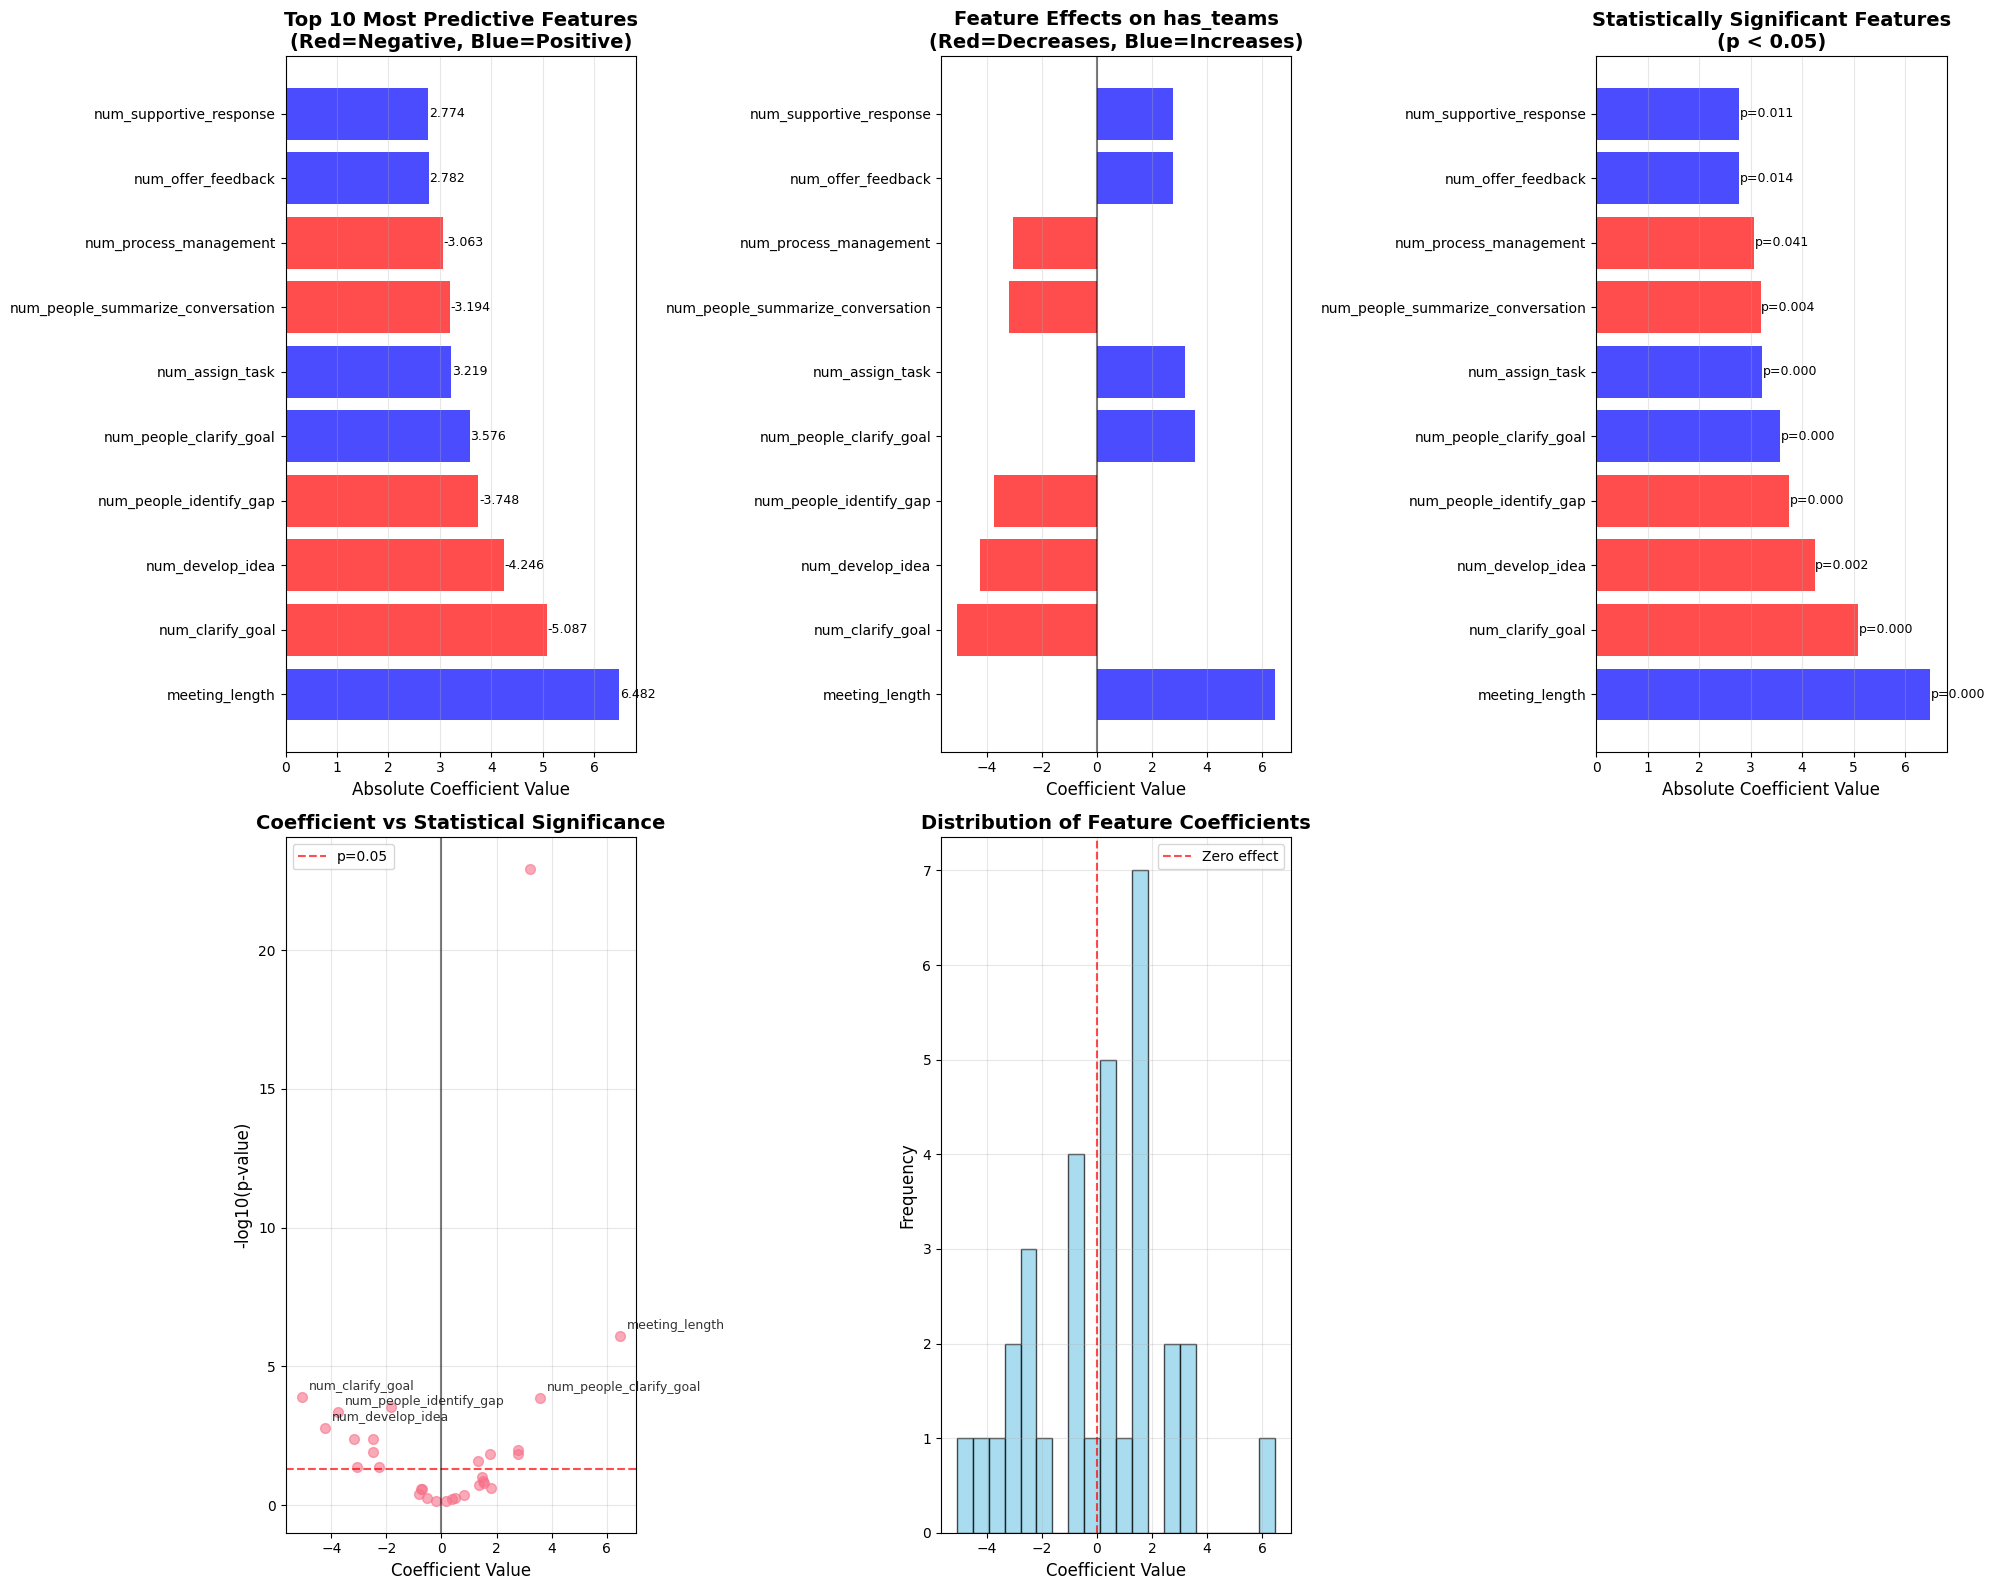


SUMMARY STATISTICS:
Total features analyzed: 32
Positive coefficients: 18
Negative coefficients: 14
Statistically significant (p < 0.05): 16
Highly significant (p < 0.01): 9
Mean absolute coefficient: 1.9836
Max absolute coefficient: 6.4824


In [52]:
df = normalized_df

target = 'has_teams'  
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

Running logistic regression for target: has_funded_teams
Original features: 32
Features after variance threshold: 32
Trying method: newton
Success with method: newton

Logistic Regression Results for has_funded_teams
Training samples: 124
Test samples: 32
ROC AUC: 0.596
Accuracy: 0.562

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:       has_funded_teams   No. Observations:                  124
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                           31
Date:                Wed, 27 Aug 2025   Pseudo R-squ.:                  0.2990
Time:                        17:18:38   Log-Likelihood:                -56.941
converged:                       True   LL-Null:                       -81.229
Covariance Type:            nonrobust   LLR p-value:                   0.02315
                 coef    std err          z      P>|z|     

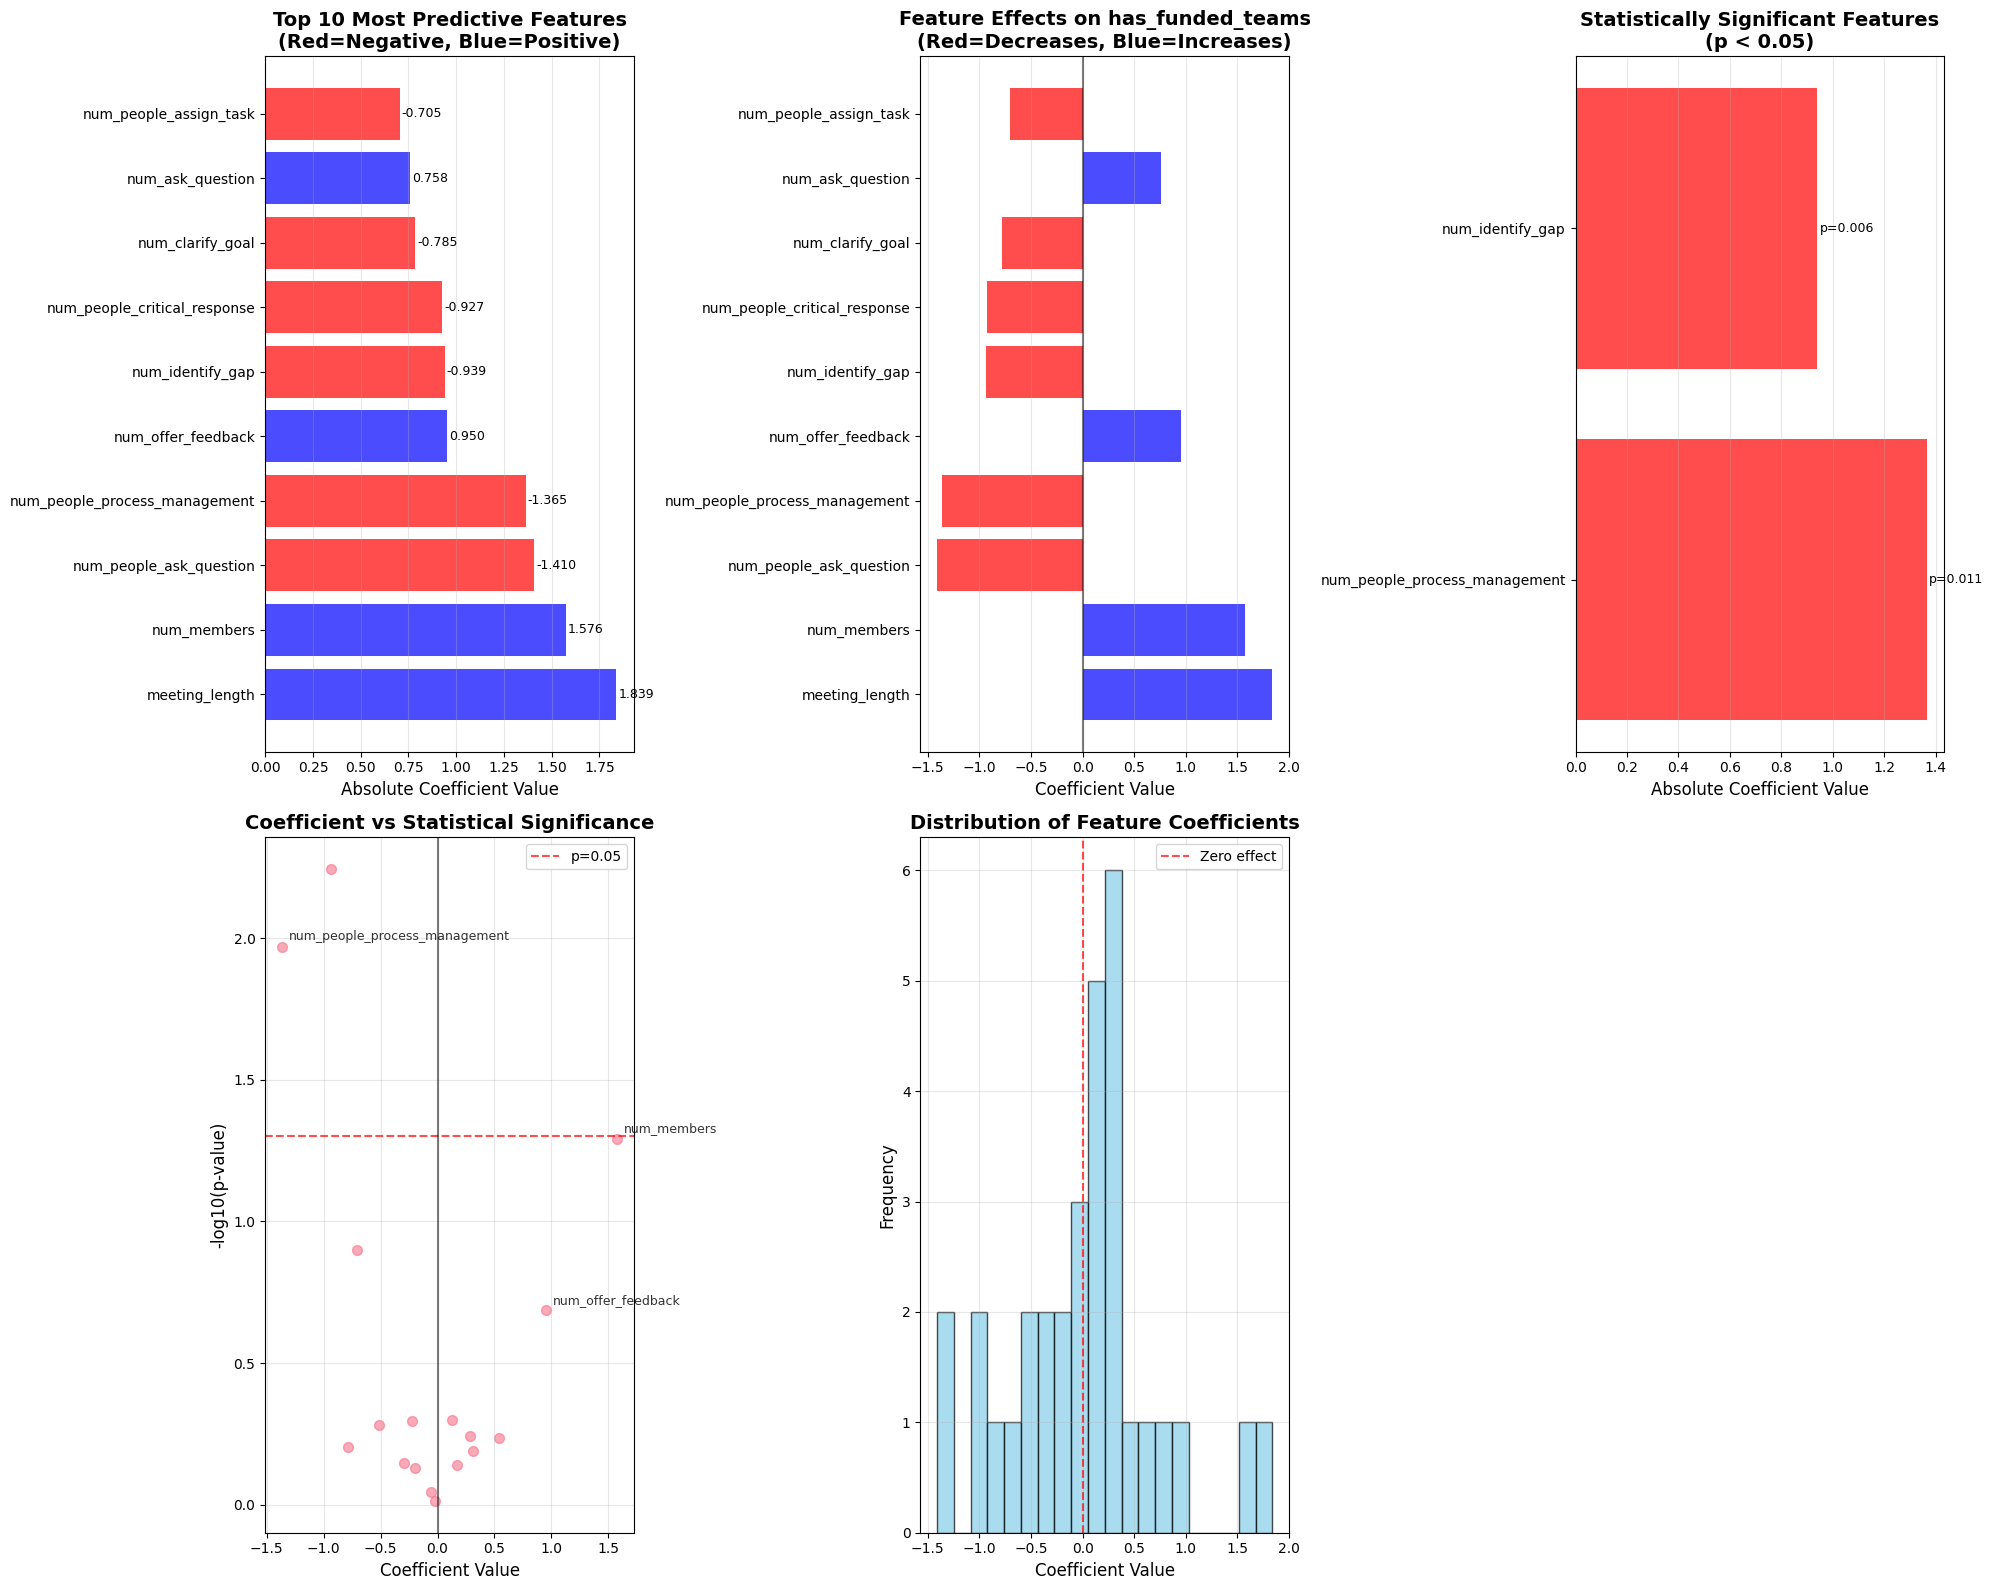


SUMMARY STATISTICS:
Total features analyzed: 32
Positive coefficients: 17
Negative coefficients: 15
Statistically significant (p < 0.05): 2
Highly significant (p < 0.01): 1
Mean absolute coefficient: 0.5322
Max absolute coefficient: 1.8387


In [53]:
df = normalized_df
target = 'has_funded_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

### Linear regression (use all_data_df)

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import statsmodels.api as sm
from scipy import stats
import numpy as np

import statsmodels.api as sm
from scipy import stats
import numpy as np


def run_linear_regression_with_stats(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run linear regression with statistical significance testing using statsmodels.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams'] and not col.endswith('_numeric')]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train)
    X_test_with_const = sm.add_constant(X_test)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    
    return results, results_df, scaler

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def run_linear_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """Run linear regression for continuous targets."""
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    
    X_train_scaled_df = pd.DataFrame(X_train, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test, columns=feature_columns, index=X_test.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_,
        'abs_coefficient': np.abs(model.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance



In [58]:
# Run linear regression
print("Predicting num_teams (regression):")
model1, scaler1, importance1 = run_linear_regression_with_stats(all_data_df, 'num_teams')



Predicting num_teams (regression):
Linear Regression Results for num_teams
Training samples: 124
Test samples: 32
R² Score: 0.221
Adjusted R²: 0.083
F-statistic: 1.360
F-statistic p-value: 0.132

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:              num_teams   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.360
Date:                Wed, 27 Aug 2025   Prob (F-statistic):              0.132
Time:                        17:26:24   Log-Likelihood:                -157.10
No. Observations:                 124   AIC:                             378.2
Df Residuals:                      92   BIC:                             468.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                   

In [59]:
print("\nPredicting num_funded_teams (regression):")
model2, scaler2, importance2 = run_linear_regression_with_stats(all_data_df, 'num_funded_teams')


Predicting num_funded_teams (regression):
Linear Regression Results for num_funded_teams
Training samples: 124
Test samples: 32
R² Score: 0.174
Adjusted R²: 0.088
F-statistic: 1.385
F-statistic p-value: 0.119

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:       num_funded_teams   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     1.385
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.119
Time:                        15:26:17   Log-Likelihood:                -91.186
No. Observations:                 124   AIC:                             246.4
Df Residuals:                      92   BIC:                             336.6
Df Model:                          31                                         
Covariance Type:            nonrobust                    

In [ ]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# L1 Regularization (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

# L2 Regularization (Ridge) 
ridge_model = LogisticRegression(penalty='l2', C=1.0, random_state=42)

# For linear regression
lasso_linear = Lasso(alpha=1.0, random_state=42)
ridge_linear = Ridge(alpha=1.0, random_state=42)




### cross validation

In [ ]:
### Cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score

# For logistic regression
def evaluate_logistic_model(X, y, model, cv_folds=5):
    # Cross-validation for accuracy
    cv_accuracy = cross_val_score(model, X, y, cv=cv_folds, scoring='accuracy')
    
    # Cross-validation for ROC AUC
    cv_auc = cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc')
    
    print(f"Cross-validation Accuracy: {cv_accuracy.mean():.3f} (+/- {cv_accuracy.std() * 2:.3f})")
    print(f"Cross-validation ROC AUC: {cv_auc.mean():.3f} (+/- {cv_auc.std() * 2:.3f})")
    
    return cv_accuracy, cv_auc

# For linear regression
def evaluate_linear_model(X, y, model, cv_folds=5):
    # Cross-validation for R²
    cv_r2 = cross_val_score(model, X, y, cv=cv_folds, scoring='r2')
    
    # Cross-validation for MSE
    cv_mse = cross_val_score(model, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    
    print(f"Cross-validation R²: {cv_r2.mean():.3f} (+/- {cv_r2.std() * 2:.3f})")
    print(f"Cross-validation MSE: {-cv_mse.mean():.3f} (+/- {cv_mse.std() * 2:.3f})")
    
    return cv_r2, cv_mse

### feature importance and effect size

In [ ]:
def analyze_feature_importance(model, feature_names, X, y):
    """Analyze feature importance beyond just p-values"""
    
    # Fit the model
    model.fit(X, y)
    
    # Get coefficients
    if hasattr(model, 'coef_'):
        coefficients = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
    else:
        coefficients = model.feature_importances_
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients),
        'effect_size': np.abs(coefficients) / np.std(X, axis=0)  # Standardized effect size
    })
    
    # Sort by absolute coefficient
    importance_df = importance_df.sort_values('abs_coefficient', ascending=False)
    
    # Add practical significance categories
    importance_df['practical_significance'] = pd.cut(
        importance_df['effect_size'], 
        bins=[0, 0.1, 0.3, 0.5, np.inf],
        labels=['Negligible', 'Small', 'Medium', 'Large']
    )
    
    print("Feature Importance Analysis:")
    print("=" * 50)
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    plt.subplot(1, 2, 1)
    plt.barh(range(len(top_features)), top_features['abs_coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Absolute Coefficient')
    plt.title('Feature Importance (Absolute Coefficients)')
    
    plt.subplot(1, 2, 2)
    plt.barh(range(len(top_features)), top_features['effect_size'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Standardized Effect Size')
    plt.title('Feature Importance (Effect Sizes)')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df